<h1>This notebook contains a step-by-step procedure to go from searching a point source to fitting diffuse emission models, plus background, to COSI data using stan</h1>

<h2>Import things we will need (and some more verbose)</h2>

In [2]:
import ROOT as M
import numpy as np
import scipy.optimize as op
from scipy.interpolate import RectBivariateSpline
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
mpl.style.use('thomas')
import time
from astropy.time import Time
from astropy.stats import bayesian_blocks

from COSIpy_tools import * # specific routines for use with COSI and MEGAlib data

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tqdm
from IPython.display import Image

import emcee
import corner

import stan_utility
import pystan
import pickle

# Load MEGAlib into ROOT
M.gSystem.Load("$(MEGAlib)/lib/libMEGAlib.so")

# Initialize MEGAlib
G = M.MGlobal()
G.Initialize()

True

In [3]:
import importlib
%reload_ext autoreload
%autoreload 2
%aimport COSIpy_tools

<h3>For python to work with MEGAlib, we need to have ROOT (e.g. in the MEGAlib directories) in the python PATH</h3>

In [4]:
sys.path

['/Users/thomassiegert/python/COSIpy',
 '/Users/thomassiegert/python/testing/tsiegert_tools',
 '',
 '/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages',
 '/Users/thomassiegert/.virtualenvs/testing',
 '/Users/thomassiegert/MEGAlib/MEGAlib/external/root_v6.14.08/lib',
 '/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python37.zip',
 '/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7',
 '/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/site-packages',
 '/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/IPython/extensions',
 '/Users/thomassiegert/.ipython']

<h2>Read in MEGAlib-simulated data set of three days of 511 keV data:</h2>

<h3>511 keV bin (10 keV ~ 3 instrumental resolutions)</h3>

<h4>Background + source</h4>

In [9]:
dir = 'datasets/511keV_sim3x/SRCplusBG_0506-0516keV/'
COSI_Data_sim511 = read_COSI_DataSet(dir)


Switched to file /Users/thomassiegert/python/COSIpy/datasets/511keV_sim3x/SRCplusBG_0506-0516keV/../BGonly_0506-0516keV/ThreeDayBG_CE_0506-0516keV.tra.gz
Switched to file /Users/thomassiegert/python/COSIpy/datasets/511keV_sim3x/SRCplusBG_0506-0516keV/../SRConly_0506-0516keV/511keV_sim3x_CE_0506-0516keV.tra.gz


<h4>Source only</h4>

In [10]:
dir = 'datasets/511keV_sim3x/SRConly_0506-0516keV/'
COSI_Data_sim511_SRConly = read_COSI_DataSet(dir)

<h4>Background only</h4>

In [11]:
dir = 'datasets/511keV_sim3x/BGonly_0506-0516keV/'
COSI_Data_sim511_BGonly = read_COSI_DataSet(dir)

<h3>Spectrum between 400 and 620 keV:</h3>

<h4>Background + source</h4>

In [12]:
dir = 'datasets/511keV_sim3x/SRCplusBG_0400-0620keV/'
COSI_Data_sim511_spec = read_COSI_DataSet(dir)


Switched to file /Users/thomassiegert/python/COSIpy/datasets/511keV_sim3x/SRCplusBG_0400-0620keV/../BGonly_0400-0620keV/ThreeDayBG_CE_0400-0620keV.tra.gz
Switched to file /Users/thomassiegert/python/COSIpy/datasets/511keV_sim3x/SRCplusBG_0400-0620keV/../SRConly_0400-0620keV/511keV_sim3x_CE_0400-0620keV.tra.gz


<h4>Source only</h4>

In [13]:
dir = 'datasets/511keV_sim3x/SRConly_0400-0620keV/'
COSI_Data_sim511_spec_SRConly = read_COSI_DataSet(dir)

<h4>Background only</h4>

In [14]:
dir = 'datasets/511keV_sim3x/BGonly_0400-0620keV/'
COSI_Data_sim511_spec_BGonly = read_COSI_DataSet(dir)

<h3>Get hours of observation:</h3>

In [15]:
t0, tmax = minmax(minmin(COSI_Data_sim511[0]['TimeTags'])/3600)

In [16]:
n_hours = np.round(tmax).astype(int)

In [17]:
print(t0,tmax,n_hours)

0.0 71.9863413547145 72


<h3>Plot of how the temporal variation (light-curve) looks like</h3>

(0.0, 72)

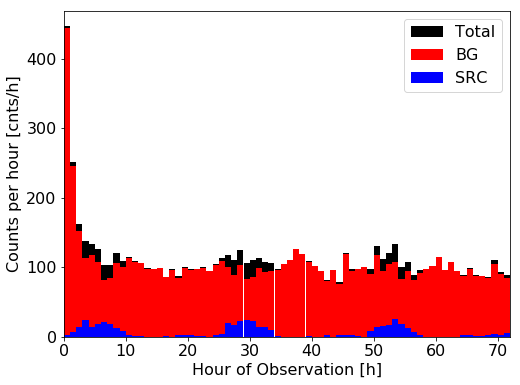

In [18]:
tmp = plt.hist(minmin(COSI_Data_sim511[0]['TimeTags'])/3600,bins=np.arange(n_hours+1),label='Total')
tmp2 = plt.hist(minmin(COSI_Data_sim511_BGonly[0]['TimeTags'])/3600,bins=np.arange(n_hours+1),label='BG')
tmp1 = plt.hist(minmin(COSI_Data_sim511_SRConly[0]['TimeTags'])/3600,bins=np.arange(n_hours+1),label='SRC')
plt.xlabel('Hour of Observation [h]')
plt.ylabel('Counts per hour [cnts/h]')
plt.legend()
plt.xlim(t0,n_hours)

<h3>Construct pointings with high resolution (to get an impression of how much the response changes with time/angle<br>This is too much for most applications / science cases because the more triggers, the more pointings and thus the more operations have to be performed for convolving the response later.<br>
    1 to 5 deg should be optimal (for stability vs. instrumental resolution vs. computational effort vs. accuracy)</h3>

In [19]:
xs, ys, zs, dt = construct_pointings(COSI_Data_sim511,angle_threshold=0.1)

<h4>Load background response</h4>

In [20]:
background_response, calc_this = load_BackGroundResponse()

<h4>Load (non-zero) sky response (grid)</h4>

In [21]:
NonZeroResponseGrid = load_NonZeroResponseGrid(calc_this=calc_this)

<h4>Check out dimensions:</h4>

In [22]:
background_response.shape,NonZeroResponseGrid.shape

((4587,), (36, 72, 4587))

<h3>Calculate the response of a point source at (l/b) = (-20,-40), with a flux of 3e-4 ph/cm2/s in the 511 keV line, for the current data set (and pointing definition) per hour of observation.<br> <br>The observation period (i.e. the time at which the fits will be performed later) of one hour are fixed right now. This may change later for arbitrarily defined cases (similar to energy).</h3>

In [23]:
l_src, b_src, flux_src = -20, -40, 3e-3
sky_response_model = calc_PS_response_hourly(xs,ys,zs,dt,
                                             l_src,b_src,
                                             NonZeroResponseGrid,flux_src,
                                             'look-up',
                                             n_hours)

<h4>Check out dimensions:</h4>

In [24]:
sky_response_model.shape

(72, 4587)

In [25]:
hs = np.arange(n_hours) # definition of hours of observation (for plotting)

<h4>Sky response of chosen point source position in this case.<br>The response is not entirely symmetric not a simple replication in three days because the path of COSI around/on Earth is changing slightly.</h4>

Text(0, 0.5, 'Expected model counts [cnts/h]')

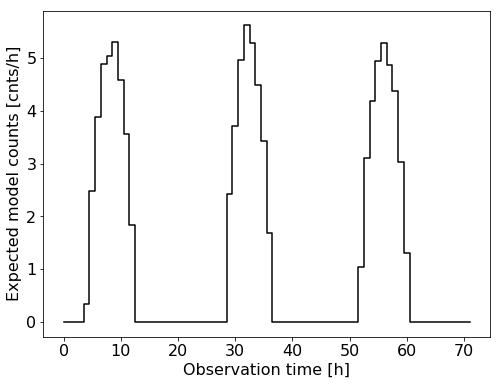

In [26]:
plt.step(hs,np.sum(sky_response_model,axis=1),where='mid')
plt.xlabel('Observation time [h]')
plt.ylabel('Expected model counts [cnts/h]')

<h4>Define FISBEL bins (standard 5x5deg) as well as hourly tags</h4>

In [27]:
fisbelbins = FISBEL(1650,0)
bb = (np.array(fisbelbins[0]))[:,0]#-np.pi/2.
ll = (np.array(fisbelbins[0]))[:,1]#-np.pi

dbb = (np.array(fisbelbins[1]))[:,0].reshape(1650,)
dll = (np.array(fisbelbins[1]))[:,1].reshape(1650,)

pp_edges = np.linspace(0,np.pi,37)
pp_min = pp_edges[0:-1]
pp_max = pp_edges[1:]
pp = (pp_max+pp_min)/2.
dpp = (pp_max-pp_min)

In [28]:
tdx_sim511 = np.array(hourly_tags(COSI_Data_sim511,n_hours=n_hours))
tdx_sim511 = tdx_sim511.reshape(1,n_hours)

<h3>Get binned data in same data space as BG and SKY response:<br><br>I want this to be faster because it can take very long if multiple energy bins are used...</h3>

In [29]:
binned_data_sim511 = get_binned_data_hourly(COSI_Data_sim511,tdx_sim511,pp,bb,ll,dpp,dbb,dll,n_hours=n_hours)

<h4>Plot of binned data. Should be the same as before (cross-check)</h4>

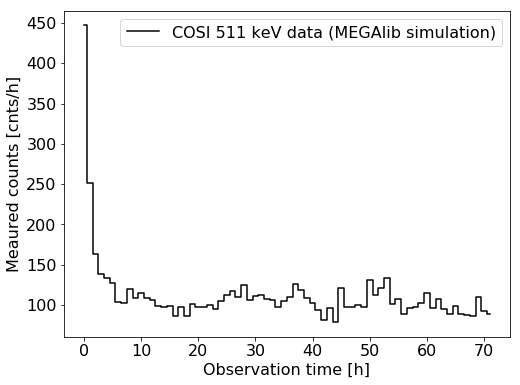

In [30]:
plt.step(hs,np.sum(binned_data_sim511,axis=(1,2)),where='mid',label='COSI 511 keV data (MEGAlib simulation)')
plt.xlabel('Observation time [h]')
plt.ylabel('Meaured counts [cnts/h]')
plt.legend()

<h3>Let's try to fit a point source to the data, searching for its position, its flux, and the background normalisation simultaneously.<br> This should fail because the background is not constant in time...</h3>

In [76]:
# only use the non-zero entries
tmp_data = (binned_data_sim511.reshape(72,36*1650))[:,calc_this]
# cross-check number of photons simulated
tot = np.sum(tmp_data)


# set 4 dimensions, one for each fit parameters
# 20 walkers >> 4 dimensions
ndim, nwalkers = 4, 20
# initial guess, here close to the true values
guess = np.array([1e-2,tot/n_hours, 0, 0])
# add random points around that guess for each walker differently
pos = guess[:, None] + np.random.randn(ndim,nwalkers)*np.repeat([1e-4,0.1,1,1],nwalkers).reshape(ndim,nwalkers)
pos = pos.T

# make sure we use the correct observation again
idx = tdx_sim511

xs, ys, zs, dt = construct_pointings(COSI_Data_sim511,angle_threshold=5)

# cross check number of photons and number of pointings
print(tot,len(zs))

# set up sampler
sampler = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                lnprob_PSsearchFlux_hourly,
                                args=(tmp_data,
                                      NonZeroResponseGrid,
                                      xs,ys,zs,
                                      background_response,
                                      dt,
                                      'look-up',
                                      n_hours)) # set up sampler
# sample (here only 200 because it alrady takes a long, and for the purpose of illustration)
_ = sampler.run_mcmc(pos, 200, progress=True) # sample

8074.0 808


100%|██████████| 200/200 [05:44<00:00,  1.70s/it]


<h4>Chains for the four fitted parameters</h4>

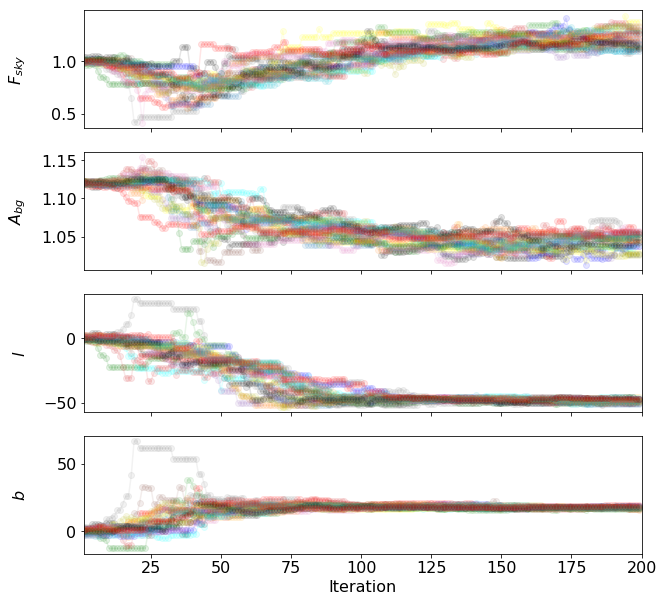

In [153]:
# to have useful numbers to plot, we scale them
scl = [1e2,1e-2,1,1]

fig, axes = plt.subplots(ndim, figsize=(10, 2.5*ndim), sharex=True)
samplesg = sampler.get_chain()*scl
labels = ["$F_{sky}$", "$A_{bg}$", "$l$", "$b$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.arange(len(samplesg)),samplesg[:, :, i], alpha=0.1,marker='o')
    ax.set_xlim(1, len(samplesg))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("Iteration");

<h3>Wait, what is the correct answer? We are looking at the wrong model (in this case we know the truth), so the answer is most certainly be wrong:<br> If at all, there should be a point source in the galactic centre, where the most photon flux comes from - but since this is totally background dominated (and the BG changes with time), this fit basically searches where most of the Compton circles overlap!</h3>

<h4>Check posterior probability</h4>

Text(0, 0.5, 'Log(Posterior probability)')

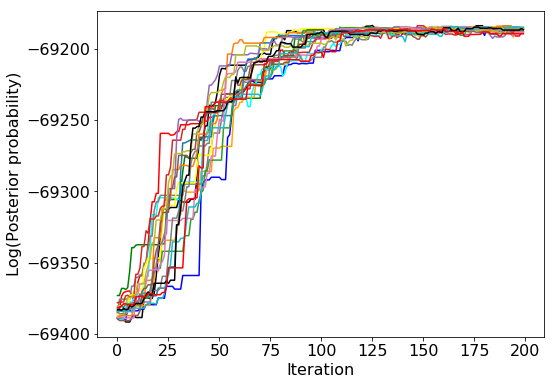

In [154]:
samplesf = sampler.flatchain
samplesf.shape
plt.plot(sampler.lnprobability)
plt.xlabel('Iteration')
plt.ylabel('Log(Posterior probability)')

<h4>And make a corner plot from iterations when things somewhat converged, here maybe at iteration 125 (don't take this to the extreme!!! only because it looks converged in this case doesn't mean it truly is converged!!!)</h4>

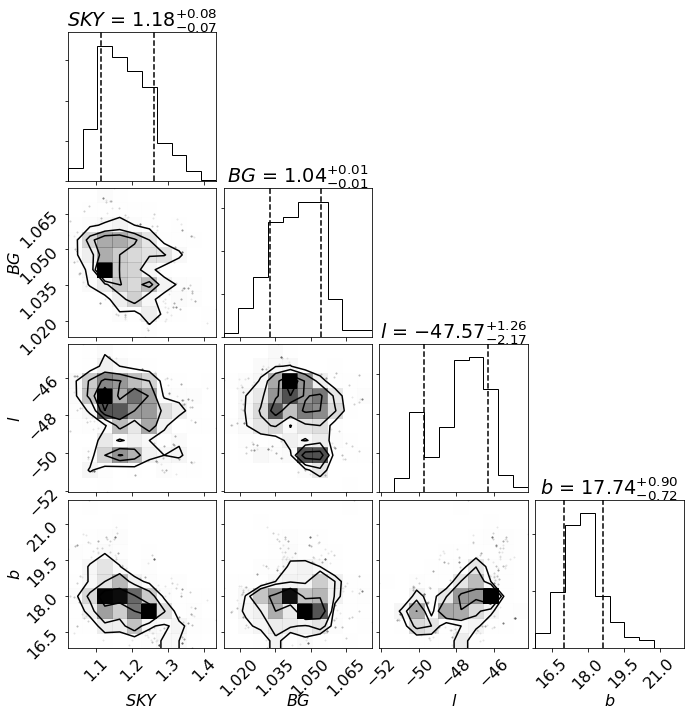

In [156]:
tmp = corner.corner(samplesf[125*nwalkers:,:]*scl, labels=["$SKY$","$BG$", "$l$", "$b$"],
                    quantiles=[0.5-0.683/2,0.5+0.683/2],show_titles=True,
                    #range=[(0.0,2.5),(0.6,1.4),(-25,20),(-10,30)],
                    bins=10)
tmp.set_size_inches(10,10)

<h3>It indeed found something 'significant' at a certain source position, with a background amplitude close to the mean of all hours.<br><br>Now, let's visualise this, and make a plot of the residuals in data space:<h3>

In [31]:
tdxh = tdx_sim511[0,0]['Indices'][0]
COSI_Data_sim511[0]['Chi galactic'][tdxh[0]]

0.8360928533706267

In [32]:
# helper function just for here to check how circles accumulate on the sky
def histogram_COSI_circles(COSI_data,tdx,lbin=5,bbin=5,color='black'):
    l_bins = np.arange(-180,180+lbin,lbin)
    b_bins = np.arange(-90,90+bbin,bbin)
    pic_arr = np.zeros((int(360/lbin),int(180/bbin)))
    
    for i in range(len(tdx)):
        c1 = circle_on_the_sky(np.rad2deg(COSI_data[0]['Chi galactic'][tdx[i]])-180,
                       -np.rad2deg(COSI_data[0]['Psi galactic'][tdx[i]])+90,
                       np.rad2deg(COSI_data[0]['Phi'][tdx[i]]))
        tmp = np.histogram2d(c1[0],c1[1],bins=(l_bins,b_bins))
        pic_arr += tmp[0]

    return pic_arr

In [33]:
binsize = 5
l_bins = np.arange(-180,180+binsize,binsize)
b_bins = np.arange(-90,90+binsize,binsize)

In [34]:
# init map with zero entries
circle_map = np.zeros((int(360/binsize),int(180/binsize)))
# loop over hours of observation (in which several photon triggers are stored)
for h in tqdm(range(n_hours)):
    circle_map += histogram_COSI_circles(COSI_Data_sim511,tdx_sim511[0,h]['Indices'][0],
                                         lbin=binsize,bbin=binsize,color='black')

<h3>Plot of all circles together (should be similar to the exposure map, though not entire because we simply add ALL circles, equally weighted).<br>Also plotted are the samples from the fit, showing they cluster around the highest 'circle density':</h3>

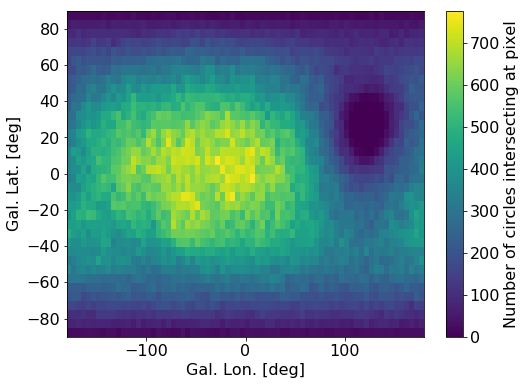

In [35]:
plt.pcolormesh(l_bins,b_bins,circle_map.T)
#plt.plot(samplesf[:,2],samplesf[:,3],
#         'r.',markersize=2,alpha=0.1)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.colorbar(label='Number of circles intersecting at pixel')

<h4>Use median of 'converged' samples to get a point estimate of the fitted parameters:</h4>

In [172]:
fit_par = np.median(samplesf[125*nwalkers:,:],axis=0)
# and std for estimate of uncertainty:
fit_err = np.std(samplesf[125*nwalkers:,:],axis=0)

In [173]:
fit_par,fit_err

(array([ 1.18001631e-02,  1.04431331e+02, -4.75680636e+01,  1.77449020e+01]),
 array([7.10018502e-04, 1.05573372e+00, 1.44678922e+00, 8.85078460e-01]))

<h4>Calculate fitted BG and fitted SKY:</h4>

In [177]:
fitted_bg = np.repeat(background_response,n_hours).reshape(background_response.shape[0],n_hours).T*fit_par[1]
fitted_sky = calc_PS_response_hourly(xs,ys,zs,dt,
                                     fit_par[2],fit_par[3],
                                     NonZeroResponseGrid,
                                     fit_par[0],
                                     'look-up',
                                     n_hours)
fitted_model = fitted_bg+fitted_sky

In [178]:
fitted_bg.shape,fitted_sky.shape,fitted_model.shape

((72, 4587), (72, 4587), (72, 4587))

<h4>And sum over phi, psi, and chi to get counts per hour for visual inspection (yes, 'chi-by-eye')</h4>

In [183]:
fitted_bg_hourly = np.sum(fitted_bg,axis=1)
fitted_sky_hourly = np.sum(fitted_sky,axis=1)
fitted_model_hourly = np.sum(fitted_model,axis=1)

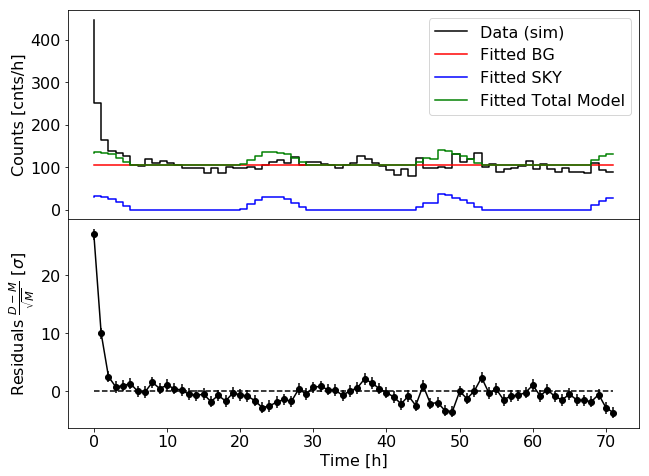

In [184]:
data_hourly = np.sum(tmp_data.astype(int),axis=1)

fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(10.24,7.68))
plt.subplots_adjust(hspace=0)
ax[0].step(hs,data_hourly,label='Data (sim)')
ax[0].step(hs,fitted_bg_hourly,label='Fitted BG')
ax[0].step(hs,fitted_sky_hourly,label='Fitted SKY')
ax[0].step(hs,fitted_model_hourly,label='Fitted Total Model')

ax[1].errorbar(hs,(data_hourly-fitted_model_hourly)/np.sqrt(fitted_model_hourly),
               marker='o',linestyle='-',yerr=np.repeat(1,n_hours))
ax[1].plot(hs,np.zeros(n_hours),linestyle='--',color='black')

ax[1].set_xlabel('Time [h]')
ax[1].set_ylabel(r'Residuals $\frac{D-M}{\sqrt{M}}$ [$\sigma$]')

ax[0].set_ylabel('Counts [cnts/h]')

ax[0].legend()

In [36]:
tmp_data = (binned_data_sim511.reshape(72,36*1650))[:,calc_this]
data_hourly = np.sum(tmp_data.astype(int),axis=1)

<h3>Clearly, the strong background feature around hour 0 is dragging the sky (blue) into a certain position, which makes the fit completely useless.<br><br>We need something that tells us how the background is changing - a background tracer:<br>We can use the photo events to estimate the pointing-to-pointing (or hour-to-hour, timebin-to-timebin, ...) variation. This is 'arbitrary', however the photo events are closest to the Compton events in terms of temporal variation, and the contribution from the sky is minimal (check that case by case).<br><br>So, let's define a tracer:</h3>

In [37]:
# read in photo events from a larger spectral region (also contains 511 keV line!)
dir = 'datasets/511keV_sim3x/tracers/SRCplusBG_0400-0620keV/'
COSI_Data_sim_PE_tracer = read_COSI_DataSet_PE(dir)


Switched to file /Users/thomassiegert/python/COSIpy/datasets/511keV_sim3x/tracers/SRCplusBG_0400-0620keV/../BGonly_0400-0620keV/ThreeDayBG_PE_0400-0620keV.tra.gz
Switched to file /Users/thomassiegert/python/COSIpy/datasets/511keV_sim3x/tracers/SRCplusBG_0400-0620keV/../SRConly_0400-0620keV/511keV_sim3x_PE_0400-0620keV.tra.gz


In [38]:
# histogram the data
tracer_histogram = np.histogram(minmin(COSI_Data_sim_PE_tracer[0]['TimeTags'])/3600,bins=np.arange(n_hours+1))

In [39]:
# normalise tracer to the number of photons in the data set
# (nor required but useful for further calculations and the meaning of the fitted parameters)
# a fit parameter of 1 then means there is no sky signal, below 1 means there is signal, above 1 means something went wrong
tracer = tracer_histogram[0]/np.mean(tracer_histogram[0])*np.mean(data_hourly)

<h3>Actually done. What does it look like?</h3>

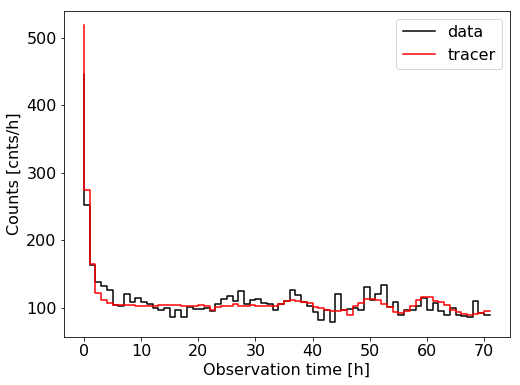

In [40]:
plt.step(hs,np.sum(binned_data_sim511,axis=(1,2)),label='data')
plt.step(hs,tracer,label='tracer')
plt.xlabel('Observation time [h]')
plt.ylabel('Counts [cnts/h]')
plt.legend()

<h3>Looks good. Let's try again with this tracer:</h3>

In [193]:
# only use the non-zero entries
tmp_data = (binned_data_sim511.reshape(72,36*1650))[:,calc_this]
# cross-check number of photons simulated
tot = np.sum(tmp_data)


# set 4 dimensions, one for each fit parameters
# 20 walkers >> 4 dimensions
ndim, nwalkers = 4, 20
# initial guess, here close to the true values
guess = np.array([1e-2,1., 0, 0]) # note the change in BG normalisation == 1
# add random points around that guess for each walker differently
pos = guess[:, None] + np.random.randn(ndim,nwalkers)*np.repeat([1e-4,0.1,1,1],nwalkers).reshape(ndim,nwalkers)
pos = pos.T

# make sure we use the correct observation again
idx = tdx_sim511

xs, ys, zs, dt = construct_pointings(COSI_Data_sim511,angle_threshold=5)

# cross check number of photons and number of pointings
print(tot,len(zs))

# set up sampler
sampler_tr = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                lnprob_PSsearchFlux_hourly_bgtracer,
                                args=(tmp_data,
                                      NonZeroResponseGrid,
                                      xs,ys,zs,
                                      background_response,
                                      dt,
                                      'look-up',
                                      n_hours,
                                      tracer)) # set up sampler
# sample (here only 200 because it alrady takes a long, and for the purpose of illustration)
_ = sampler_tr.run_mcmc(pos, 200, progress=True) # sample

8074.0 808


100%|██████████| 200/200 [05:34<00:00,  1.61s/it]


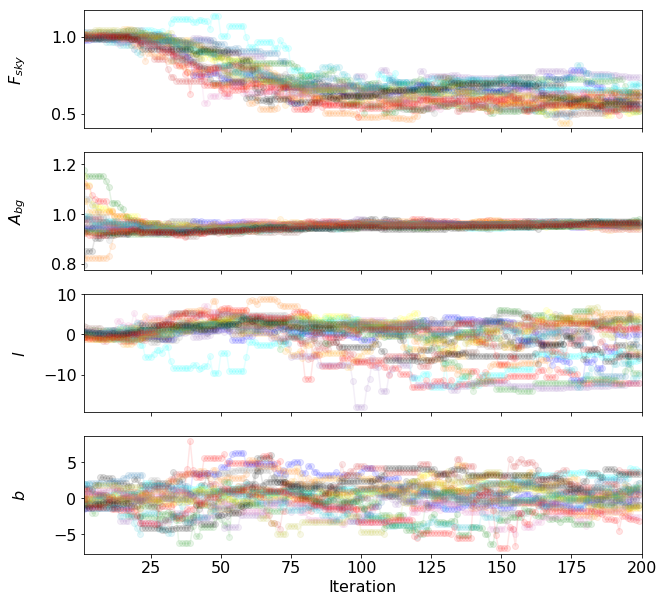

In [194]:
# to have useful numbers to plot, we scale them
scl = [1e2,1,1,1]

fig, axes = plt.subplots(ndim, figsize=(10, 2.5*ndim), sharex=True)
samples_trg = sampler_tr.get_chain()*scl
labels = ["$F_{sky}$", "$A_{bg}$", "$l$", "$b$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.arange(len(samples_trg)),samples_trg[:, :, i], alpha=0.1,marker='o')
    ax.set_xlim(1, len(samples_trg))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("Iteration");

Text(0, 0.5, 'Log(Posterior probability)')

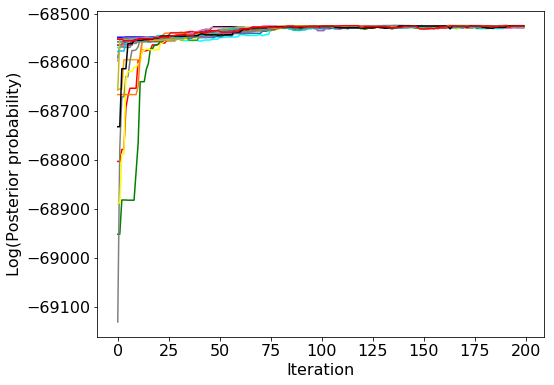

In [195]:
samples_trf = sampler_tr.flatchain
samples_trf.shape
plt.plot(sampler_tr.lnprobability)
plt.xlabel('Iteration')
plt.ylabel('Log(Posterior probability)')

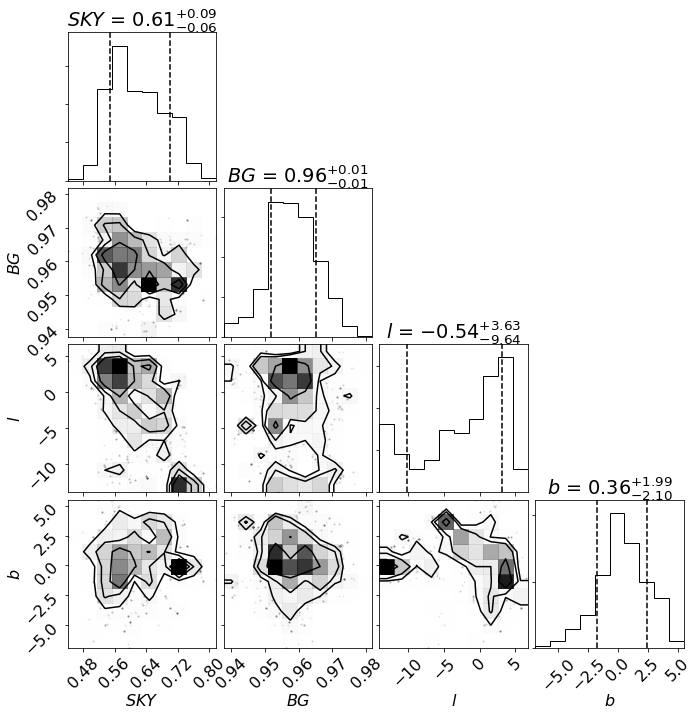

In [196]:
tmp = corner.corner(samples_trf[125*nwalkers:,:]*scl, labels=["$SKY$","$BG$", "$l$", "$b$"],
                    quantiles=[0.5-0.683/2,0.5+0.683/2],show_titles=True,
                    #range=[(0.0,2.5),(0.6,1.4),(-25,20),(-10,30)],
                    bins=10)
tmp.set_size_inches(10,10)

<h3>Something something, source detection at (l/b) = (0/0)! Clearly, the things did not converge, but the idea became clearer that the background has to determined by the data itself and can certainly not assumed to be constant in time.<br>Also the background amplitude is decreased as expected from a source contribution.<br>Residuals again:</h3>

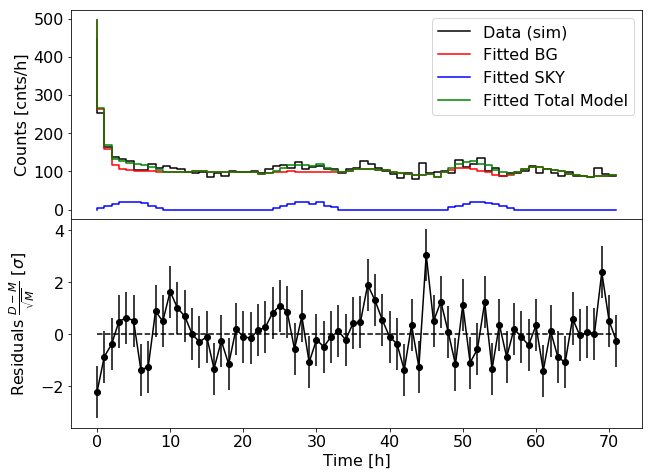

In [198]:
fit_par_tr = np.median(samples_trf[125*nwalkers:,:],axis=0)
fit_err_tr = np.std(samples_trf[125*nwalkers:,:],axis=0)

fitted_bg_tr = np.repeat(background_response,n_hours).reshape(background_response.shape[0],n_hours).T*fit_par_tr[1]*tracer[:,None]
fitted_sky_tr = calc_PS_response_hourly(xs,ys,zs,dt,
                                     fit_par_tr[2],fit_par_tr[3],
                                     NonZeroResponseGrid,
                                     fit_par_tr[0],
                                     'look-up',
                                     n_hours)
fitted_model_tr = fitted_bg_tr+fitted_sky_tr

fitted_bg_hourly_tr = np.sum(fitted_bg_tr,axis=1)
fitted_sky_hourly_tr = np.sum(fitted_sky_tr,axis=1)
fitted_model_hourly_tr = np.sum(fitted_model_tr,axis=1)

data_hourly = np.sum(tmp_data.astype(int),axis=1)

fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(10.24,7.68))
plt.subplots_adjust(hspace=0)
ax[0].step(hs,data_hourly,label='Data (sim)')
ax[0].step(hs,fitted_bg_hourly_tr,label='Fitted BG')
ax[0].step(hs,fitted_sky_hourly_tr,label='Fitted SKY')
ax[0].step(hs,fitted_model_hourly_tr,label='Fitted Total Model')

ax[1].errorbar(hs,(data_hourly-fitted_model_hourly_tr)/np.sqrt(fitted_model_hourly_tr),
               marker='o',linestyle='-',yerr=np.repeat(1,n_hours))
ax[1].plot(hs,np.zeros(n_hours),linestyle='--',color='black')

ax[1].set_xlabel('Time [h]')
ax[1].set_ylabel(r'Residuals $\frac{D-M}{\sqrt{M}}$ [$\sigma$]')

ax[0].set_ylabel('Counts [cnts/h]')

ax[0].legend()

<h3>Better.</h3>

<h3>Now that we know we need a tracer, and that we have found 'something' in the sky, let's check if we can find the diffuse emission that we actually simulated.<br><br> First, we introduce how diffuse emission is working, then we will move our fits to 'stan' and fit a full-sky model with varying background parameters, finally we check what we can find out if we are agnostic about the true emission model (knowns become unknowns):</h3>

<h4>First, we a 'pre-calculating' the response for each pointing in our data set.<br>This can take a while, but we only have to do it once (for a particular data set), and re-use it whenever we want to fit another sky model:</h4>

In [41]:
# first calculate grid of all zeniths and azimuths for all pointings
xs,ys,zs,dt = construct_pointings(COSI_Data_sim511,angle_threshold=1) # here we use one degree for precise predictions

# we define our sky-grid on a regular 5x5 pixel grid
binsize = 5
l_arrg = np.linspace(-180,180,(360/binsize)+1)
b_arrg = np.linspace(-90,90,(180/binsize)+1)
L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
l_arr = l_arrg[0:-1]+binsize/2
b_arr = b_arrg[0:-1]+binsize/2
L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

# and calculate the zeniths and azimuths on that grid for all times
zensgrid,azisgrid = zenaziGrid(xs[:,0],xs[:,1],
                               ys[:,0],ys[:,1],
                               zs[:,0],zs[:,1],
                               L_ARR.ravel(),B_ARR.ravel())
# reshape for next routines ... 
zensgrid = zensgrid.reshape(36,72,len(zs))
azisgrid = azisgrid.reshape(36,72,len(zs))

# and calculate response
#image_response_sim511 = get_image_response_from_pixelhit_hourly(NonZeroResponseGrid,zensgrid,azisgrid,dt,n_hours)

<h4>I will load the pre-calculated response from a file ... too large to upload:</h4>

In [42]:
with np.load('COSIstandata_sim511.npz',) as content:
    image_response_sim511 = content['image_response_sim511']

In [43]:
image_response_sim511.shape # (hours, b, l, phi*psi*chi)

(72, 36, 72, 4587)

<h3>We define the four spatial 511 keV components as simulated (and taken from Siegert+2016):</h3>

In [44]:
# everything is normalised to 1 (ph/cm2/s) for the fit later to fit for flux (and combinations)
NB_map = Gaussian2D(L_ARR,B_ARR,1,-1.25,-0.25,2.45,2.45)
BB_map = Gaussian2D(L_ARR,B_ARR,1,0,0,8.70,8.70)
DISK_map = Gaussian2D(L_ARR,B_ARR,1,0,0,60,10.5)
GCS_map = Gaussian2D(L_ARR,B_ARR,1,-0.06,-0.05,0.1,0.1)

<h3>Plot the Siegert+2016 511 keV map with weightings according the the paper, though 3 times more flux (to circumvent the shorter exposure:</h3>

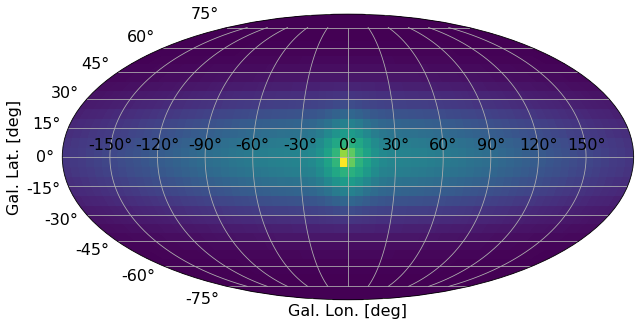

In [45]:
five11keV_map = NB_map*0.2e-3+BB_map*0.8e-3+DISK_map*1.7e-3+GCS_map*0.1e-3
plt.figure(figsize=(10.24,7.68))
plt.subplot(projection='mollweide')
plt.pcolormesh(np.deg2rad(L_ARRg),np.deg2rad(B_ARRg),five11keV_map,
               norm=colors.PowerNorm(0.25,vmin=five11keV_map.min(), vmax=five11keV_map.max()),
               cmap='viridis')
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid(True)

<h3>Note that the highest pixel is clost to the centre, however since there is no pixel at the centre, it appears at (l/b) = (-2.5/-2.5). Note also that the map is scaled by a power-law with index 0.25 (to make the disk visible).</h3>

<h3>Now, the 'convolution' of the response with the maps is simply a sum over the pixels for each of the response entries and hours.<br><br>The term cos(b)dbdl is already included in the 'pre-calculated' response:</h3>

In [46]:
conv_sky_NB = np.sum(image_response_sim511*NB_map[None,:,:,None],axis=(1,2))
conv_sky_BB = np.sum(image_response_sim511*BB_map[None,:,:,None],axis=(1,2))
conv_sky_DISK = np.sum(image_response_sim511*DISK_map[None,:,:,None],axis=(1,2))
conv_sky_GCS = np.sum(image_response_sim511*GCS_map[None,:,:,None],axis=(1,2))

<h3>This also takes a while even though the sky is only 2592 pixels and the data set only 72 hours long, the data space is always ~4500 entries which have to be carried for all calculation.<br><br>This is an important point because we can basically also fit for the shape of these Gaussians. However, the calculation for one iteration takes sveral seconds for this limited data set (the full one being about 10-15 times larger), making the complete fit almost impossible without a cluster. For this reason, we also pre-calculate (later) certain models we test and evaluate their likelihoods to obtain the parameters of interest (Gaussian widths, scale heights, spherical radii, ...):</h3>

<h4>Plot of the convolved sky models:</h4>

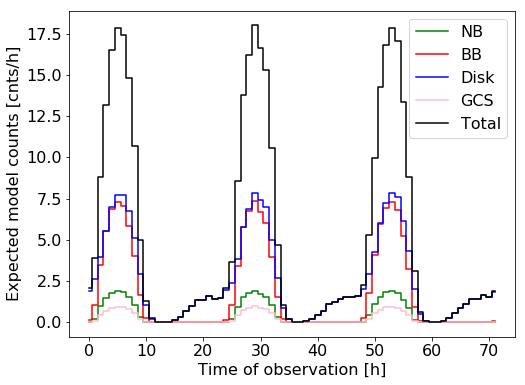

In [47]:
plt.step(hs,np.sum(conv_sky_NB,axis=1)*0.6e-3,where='mid',color='green',label='NB')
plt.step(hs,np.sum(conv_sky_BB,axis=1)*2.4e-3,where='mid',color='red',label='BB')
plt.step(hs,np.sum(conv_sky_DISK,axis=1)*5.1e-3,where='mid',color='blue',label='Disk')
plt.step(hs,np.sum(conv_sky_GCS,axis=1)*0.3e-3,where='mid',color='pink',label='GCS')
plt.step(hs,np.sum(conv_sky_NB,axis=1)*0.6e-3+
         np.sum(conv_sky_BB,axis=1)*2.4e-3+
         np.sum(conv_sky_DISK,axis=1)*5.1e-3+
         np.sum(conv_sky_GCS,axis=1)*0.3e-3,where='mid',color='black',label='Total')
plt.xlabel('Time of observation [h]')
plt.ylabel('Expected model counts [cnts/h]')

plt.legend()

<h3>You see that:<br>- the expected number of counts per hour is at most ~18 when COSI observed the galactic centre<br>- individual components like (in this case) the GCS or NB would be probably not identified because the expected counts are at most 1-3 (on a BG of > 100 counts per hour)<br>- the disk (blue) is expected to also show contributions when COSI is not pointing towards the galactic centre (i.e. obviously when observing the disk, e.g. hours 20, 45, 70), but very low counts (low surface brightness!)<br>- we might expect to see a broadened component at the galactic centre, different from a point source (dominated by BB+DISK(gal. centre) contributions).</h3>

<h4>Total 511 keV model map:</h4>

In [48]:
conv_sky_511 = conv_sky_NB*0.6e-3 + conv_sky_BB*2.4e-3 + conv_sky_DISK*5.1e-3 + conv_sky_GCS*0.3e-3
np.sum(conv_sky_511) 

361.32792324812425

<h4>About 360 photons from the sky (average 5 per hour) on top of ~8100 BG photons (average 110 per hour):</h4>

In [49]:
lima_significance((8074+361)/72,8074/72,np.sum(conv_sky_511)*np.mean(conv_sky_511))

7.2429371619750045

<h3>A certain background tracer might only be as good as the true change in the data:<br>
    For high count rates (relative), a background tracer might need to be re-scaled more often, i.e. there are times when it fits, and times when not. This has to be determined on the data itself, and may change from data set to data set and science case to science case.<br><br>Here, we fit the simulated data with the "known" sky model (most of the time a first order sky model is good enough), and vary the number of background parameters: Either we have one background parameter (like in the case before) for all times, or, in the worst case, as many parameters as hours in the observation (or even more of there are more background contributions from instrumental lines and continuum, etc...):</h3>

<h4>Define a list of background 'nodes':</h4>

In [50]:
# here starting at 1 (stan starts counting at 1, not 0; see below)
# we define the nodes equidistant to each other; 72 (hours) is particularly well-defined, because it has a lot of divisors:
all_cuts = [list(range(1,73,int(72/i))) for i in [1,2,3,4,6,8,9,12,18,24,36,72]]

In [51]:
all_cuts[0],all_cuts[6]

([1], [1, 9, 17, 25, 33, 41, 49, 57, 65])

<h4>The compile/load the stan model to fit the data with one(!) sky model and a cut BG model:</h4>

In [216]:
# compile model (if not yet compiled):
model = pystan.StanModel('fit_COSI_conved_2D.stan')

# save it to the file 'filename.pkl' for later use
with open('fit_COSI_conved_2D_new2.pkl', 'wb') as f:
    pickle.dump(model, f)


#read filename.pkl (if already compiled)
model2D = pickle.load(open('fit_COSI_conved_2D_new2.pkl', 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6f260ca3a731e91a3e55cf1f188adb4 NOW.
In file included from /var/folders/dm/j_ym90n155v7dmt1l0lbnz3h0000gn/T/tmplev91ht9/stanfit4anon_model_c6f260ca3a731e91a3e55cf1f188adb4_7306655260835473123.cpp:668:
In file included from /Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822:
/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
/var/folders/dm

<h3>What does the stan model look like?</h3>

In [217]:
print(model2D.model_code)

data {
    
    int<lower=0> N; // number of response matrix points times number of hours in data set
    int<lower=0> Nh; // number of hours of observation
    int<lower=0> y[Nh*N]; // y observations  

    real bg_model[Nh,N]; // BG model
    real conv_sky[Nh,N] ; // SKY model
  
    // background re-normalisation times
    int<lower=0> Ncuts;
    int bg_cuts[Nh];
    int bg_idx_arr[Nh];
  
    //priors on the fitted parameters
    real mu_flux;
    real sigma_flux;
    real mu_Abg;
    real sigma_Abg;
  
}


//transformed data {
//    // data
//    int data_values[Nh*N];
//  
//    for (nh in 1:Nh) {
//        for (nn in 1:N) {
//            data_values[N*(nh-1)+nn] = y[nh,nn];
//        }
//    }
//
//}


parameters {
    
    real<lower=1e-8> flux; // 511 keV line flux of conved sky model
    real<lower=1e-8> Abg[Ncuts]; // background model amplitude(s)
    
}


transformed parameters {

    // model
    real model_values[Nh*N];
    
    for (nh in 1:Nh) {
        for (nn in 1:N) 

<h3>There are a lot of things to explain (most of it elsewhere), but the most important things are listed below:<br><br>- in the model{} block, the data is fitted as distributed according to the Poisson distribution (data_values ~ poisson(model_values)<br>- the flux as well as the (many) background amplitudes have normal priors on them, with values given in the data{} block (python dictionary, see below)<br>- the fitted parameters, flux and Abg[Ncuts], are constrained to be positive (will crash otherwise because the data (counts) are positive or zero, so negative expectations are not possible</h3>

<h3>Data set to put into stan:</h3>

In [218]:
bg_response_hourly = np.repeat(background_response,n_hours).reshape(background_response.shape[0],n_hours).T
bg_response_tracer = bg_response_hourly*tracer[:,None]

Nh, Nrsp = bg_response_tracer.shape
N = Nh*Nrsp
mu_flux_scl = 1. # particularly set to one instead of 1e-3 or something (computational issues, mixing)
sigma_flux_scl = 1 # same
mu_Abg = 1.
sigma_Abg = 0.1

# background cuts for a particular set (here index 6)
bg_cuts, idx_arr, Ncuts = make_bg_cuts(all_cuts[6],n_hours)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
             Nh = Nh,
             Ncuts = Ncuts,
             bg_cuts = bg_cuts,
             bg_idx_arr = idx_arr,
             y = tmp_data.ravel().astype(int),
             bg_model = bg_response_tracer,
             conv_sky = conv_sky_511,
             mu_flux = mu_flux_scl,
             sigma_flux = sigma_flux_scl,
             mu_Abg = mu_Abg,
             sigma_Abg = sigma_Abg)

<h3>Now only optimise (point estimate) the likelihood (i.e. no parameter uncertainties):</h3>

In [219]:
init = {}
init['flux'] = 1.0
init['Abg'] = np.repeat(1,Ncuts)
op2D = model2D.optimizing(data=data2D,verbose=True,init=init,as_vector=False)
op2D

OrderedDict([('par',
              OrderedDict([('flux', array(1.72617998)),
                           ('Abg',
                            array([0.87018048, 0.99352655, 0.91843945, 0.90635666, 0.99950337,
                                   0.96418676, 0.87912099, 0.91943012, 0.96432675])),
                           ('model_values',
                            array([0.00125448, 0.00125328, 0.00125308, ..., 0.0002558 , 0.00102319,
                                   0.0002558 ])),
                           ('ppc', array([0., 0., 0., ..., 0., 0., 0.])),
                           ('model_tot',
                            array([454.43911748, 245.55295558, 159.00543772, 129.38628605,
                                   125.91230433, 123.83012486, 120.97941354, 116.77186786,
                                   122.47615856, 111.5993196 , 104.51982532, 102.95843911,
                                   102.74322033, 102.54384728, 103.62814492, 103.83105467,
                                  

Initial log joint probability = -34262.8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      12      -34242.4   0.000268056     0.0631007      0.6102      0.6102       14   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<h3>There seems to be a bug when calculating the posterior for the models. However, the ppc and fitted values for flux and background seem okay (will be fixed later; workaround below)<br><br>
TS: bug now fixed; vectors (matrices, arrays, etc.) are initiales as NaNs, so that adding somethign ot NaNs will still be NaN. Initialising as zero-vector helps, and resolves the problem.</h3>

<h3>'par' are the fitted parameters flux and Abg (here 9 time nodes), and the fitted model_values, together with the 'value' of the maximum log-posterior.<br><br>We will use this to get an estimate of how many background parameters are actually required to fit the current data set (given a certain sky model):</h3>

In [220]:
# init point estimate arrays
fit_pars_bg_all = []
fit_pars_flux_all = []
fit_pars_lp__all = []

# loop over all cuts
for c in tqdm(range(len(all_cuts))):
    bg_cuts, idx_arr, Ncuts = make_bg_cuts(all_cuts[c],n_hours)

    # dictionary for data set and prior
    data2D = dict(N = Nrsp,
                 Nh = Nh,
                 Ncuts = Ncuts,
                 bg_cuts = bg_cuts,
                 bg_idx_arr = idx_arr,
                 y = tmp_data.ravel().astype(int),
                 bg_model = bg_response_tracer,
                 conv_sky = conv_sky_511,
                 mu_flux = mu_flux_scl,
                 sigma_flux = sigma_flux_scl,
                 mu_Abg = mu_Abg,
                 sigma_Abg = sigma_Abg)
    
    # estimate
    init = {}
    init['flux'] = 1.0
    init['Abg'] = np.repeat(1,Ncuts)
    op2D = model2D.optimizing(data=data2D,init=init,as_vector=False)
    # save parameters
    fit_pars_bg_all.append(op2D['par']['Abg'])
    fit_pars_flux_all.append(op2D['par']['flux'])
    fit_pars_lp__all.append(op2D['value'])


Initial log joint probability = -34262.8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       7      -34249.3    0.00322841     0.0645341      0.9767      0.9767       10   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -34262.8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      11      -34248.7    0.00130419     0.0231525           1           1       15   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -34262.8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      11      -34248.1    0.00182737      0.158245      0.6432      0.6432       15   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint pro

<h3>Here, we now use the Akaike Information Criterion to evaluate how many parameters are necessary (the lower the AIC, the better the fit); the absolute value has no meaning:</h3>

In [221]:
n_par_arr = []
for i in range(len(all_cuts)):
    n_par_arr.append(len(all_cuts[i])+1)
n_par_arr = np.array(n_par_arr)

In [222]:
def AIC(n_par, lnlik):
    return (2*n_par) - (2*lnlik)

In [223]:
def cashstat(data,model):
    return -2*np.sum(data*np.log(model)-model-(data*np.nan_to_num(np.log(data))-data))

In [224]:
AIC_arr = []
cashstat_arr = []
for c in range(len(all_cuts)):
    reb = n_hours/len(all_cuts[c])
    tmp_model = (fit_pars_flux_all[c]*conv_sky_511 + bg_response_tracer*np.repeat(fit_pars_bg_all[c],reb)[:,None])
    stat = -0.5*cashstat(tmp_data,tmp_model)
    cashstat_arr.append(stat)
    AIC_arr.append(AIC(n_par_arr[c],stat))
AIC_arr = np.array(AIC_arr)
cashstat_arr = np.array(cashstat_arr)

Text(0.5, 1.0, 'From using log-posterior')

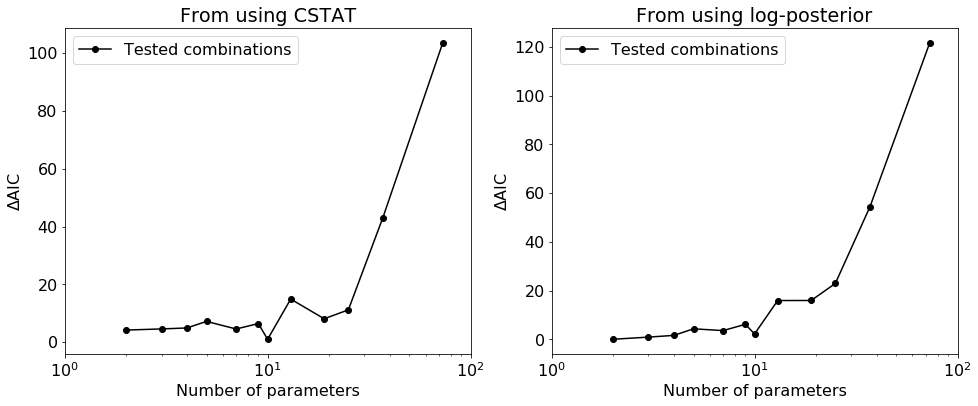

In [225]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.plot(n_par_arr,minmin(AIC_arr)+1,'o-',label='Tested combinations')
plt.xscale('log')
plt.xlim(1,100)
plt.xlabel('Number of parameters')
plt.ylabel(r'$\Delta$AIC')
plt.legend()
plt.title('From using CSTAT')

plt.subplot(122)
plt.plot(n_par_arr,minmin(AIC(n_par_arr,np.array(fit_pars_lp__all))),'o-',label='Tested combinations')
plt.xscale('log')
plt.xlim(1,100)
plt.xlabel('Number of parameters')
plt.ylabel(r'$\Delta$AIC')
plt.legend()
plt.title('From using log-posterior')

<h3>There is a minimum at 10 fitted parameters (i.e. 9 background parameters); however, all previous background models with fewer parameters fit particularly good and might be used instead;<br><br>In the following, we use 9 background parameters to fit the known diffuse emission model the check what the parameters look like:</h3>

In [226]:
len(all_cuts[6])

9

In [227]:
minmax(tmp_data)

array([0., 3.])

In [228]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts(all_cuts[6],n_hours)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
             Nh = Nh,
             Ncuts = Ncuts,
             bg_cuts = bg_cuts,
             bg_idx_arr = idx_arr,
             y = tmp_data.ravel().astype(int),
             bg_model = bg_response_tracer,
             conv_sky = conv_sky_511,
             mu_flux = mu_flux_scl,
             sigma_flux = sigma_flux_scl,
             mu_Abg = mu_Abg,
             sigma_Abg = sigma_Abg)

# sample (fit);
#fit2 = model2D.sampling(data=data2D,chains=1,iter=1500,pars=['flux','Abg'],n_jobs=-1)
fit3 = model2D.sampling(data=data2D,chains=1,iter=1000,n_jobs=-1)# only 1 chain because it kills my RAM otherwise

To run all diagnostics call pystan.check_hmc_diagnostics(fit)



Gradient evaluation took 0.090169 seconds
1000 transitions using 10 leapfrog steps per transition would take 901.69 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 209.959 seconds (Warm-up)
               175.188 seconds (Sampling)
               385.147 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[1294] is nan, but must not be nan!  (in 'fit_COSI_conved_2D.stan' at line 68)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



<h3>Summary of fitted parameters and log-posterior:</h3>

In [229]:
print(fit3.stansummary(['flux','Abg','lp__']))

Inference for Stan model: anon_model_c6f260ca3a731e91a3e55cf1f188adb4.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux     1.72  8.2e-3   0.19   1.37   1.59   1.71   1.85   2.08    525    1.0
Abg[1]   0.87  9.4e-4   0.03   0.82   0.85   0.87   0.89   0.92    777    1.0
Abg[2]    1.0  1.1e-3   0.04   0.92   0.97    1.0   1.02   1.06   1154    1.0
Abg[3]   0.92  1.0e-3   0.03   0.86    0.9   0.92   0.94   0.98    988    1.0
Abg[4]   0.91  1.2e-3   0.04   0.83   0.88   0.91   0.93    1.0    942    1.0
Abg[5]    1.0 10.0e-4   0.03   0.94   0.98    1.0   1.02   1.06    993    1.0
Abg[6]   0.97  1.0e-3   0.03   0.91   0.95   0.97   0.99   1.03    962    1.0
Abg[7]   0.88  1.3e-3   0.04   0.81   0.86   0.88   0.91   0.95    770    1.0
Abg[8]   0.92  1.1e-3   0.03   0.87    0.9   0.92   0.94   0.98    706    1.0
Abg[9]   0.97  1.0e-3   0.03    0.

<h3>Extract chain(s) to make posterior predictive checks as well as to show the model prediction in data space:</h3>

In [230]:
chains3 = fit3.extract()

In [231]:
samples = np.array([chains3['flux'],
                    chains3['Abg'][:,0],
                    chains3['Abg'][:,1],
                    chains3['Abg'][:,2],
                    chains3['Abg'][:,3],
                    chains3['Abg'][:,4],
                    chains3['Abg'][:,5],
                    chains3['Abg'][:,6],
                    chains3['Abg'][:,7],
                    chains3['Abg'][:,8]]).T

In [232]:
# number of sampled values 
nt = chains3['flux'].shape[0]
nt

500

<h4>Corner plot:</h4>

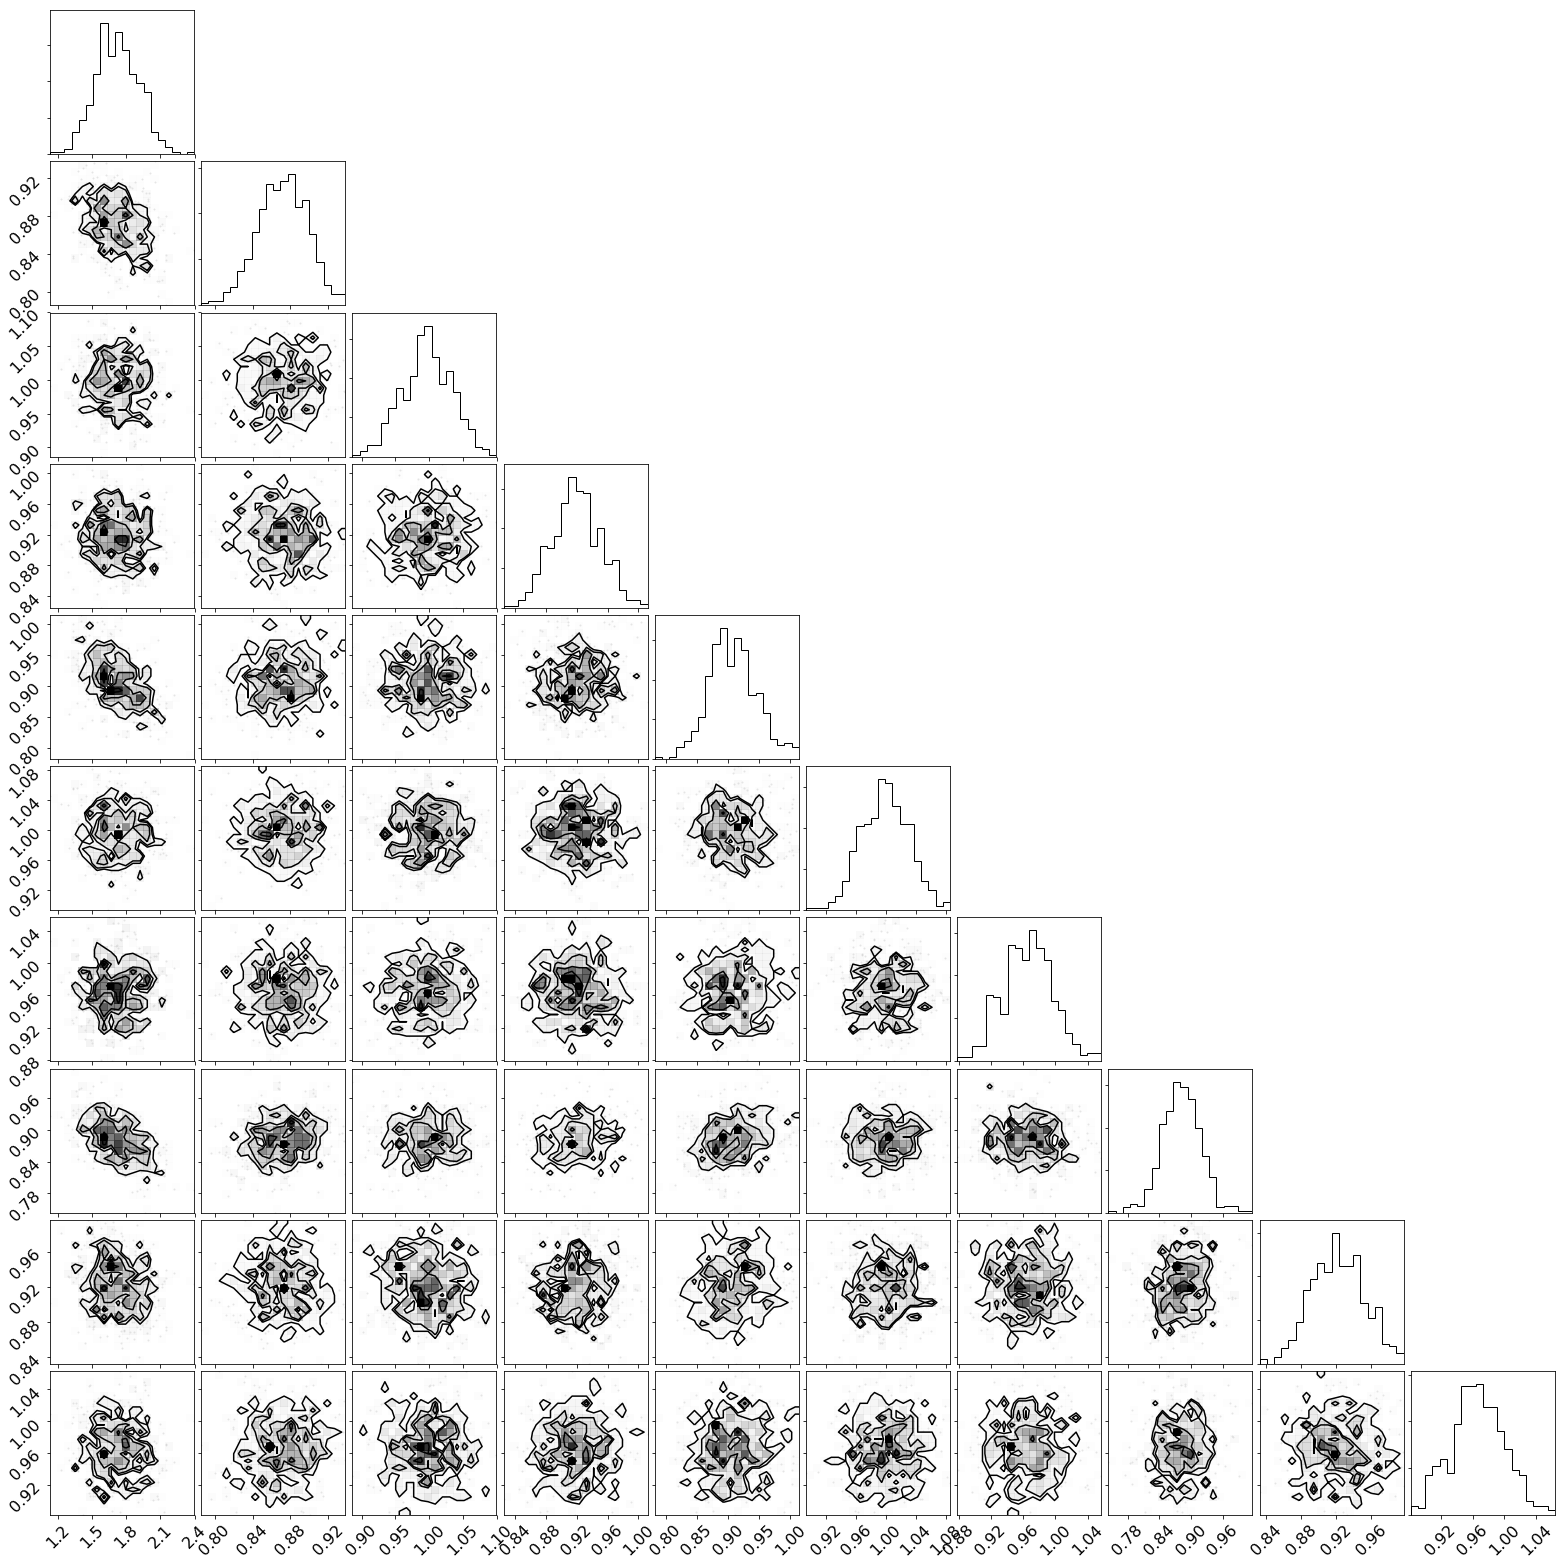

In [233]:
_ = corner.corner(samples)

<h4>Posterior distributions of fitted parameters (note the BG is 1.0 (BG only) or less (BG+SRC)):</h4>

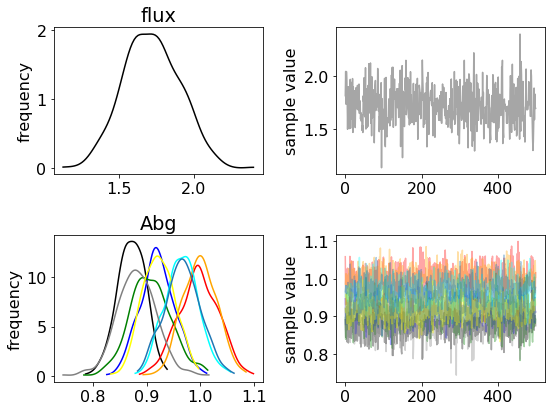

In [234]:
fit3.plot(['flux','Abg']);
plt.tight_layout()

In [261]:
s68 = 68.3/2
s95 = 95.4/2

fitted_bg = np.percentile(chains3['model_bg'],50,axis=0)
fitted_bg_errlo68 = fitted_bg-np.percentile(chains3['model_bg'],50-s68,axis=0)
fitted_bg_errhi68 = np.percentile(chains3['model_bg'],50+s68,axis=0)-fitted_bg
fitted_bg_errlo95 = fitted_bg-np.percentile(chains3['model_bg'],50-s95,axis=0)
fitted_bg_errhi95 = np.percentile(chains3['model_bg'],50+s95,axis=0)-fitted_bg


fitted_sky = np.percentile(chains3['model_sky'],50,axis=0)
fitted_sky_errlo68 = fitted_sky-np.percentile(chains3['model_sky'],50-s68,axis=0)
fitted_sky_errhi68 = np.percentile(chains3['model_sky'],50+s68,axis=0)-fitted_sky
fitted_sky_errlo95 = fitted_sky-np.percentile(chains3['model_sky'],50-s95,axis=0)
fitted_sky_errhi95 = np.percentile(chains3['model_sky'],50+s95,axis=0)-fitted_sky

fitted_tot = np.percentile(chains3['model_tot'],50,axis=0)
fitted_tot_errlo68 = fitted_tot-np.percentile(chains3['model_tot'],50-s68,axis=0)
fitted_tot_errhi68 = np.percentile(chains3['model_tot'],50+s68,axis=0)-fitted_tot
fitted_tot_errlo95 = fitted_tot-np.percentile(chains3['model_tot'],50-s95,axis=0)
fitted_tot_errhi95 = np.percentile(chains3['model_tot'],50+s95,axis=0)-fitted_tot

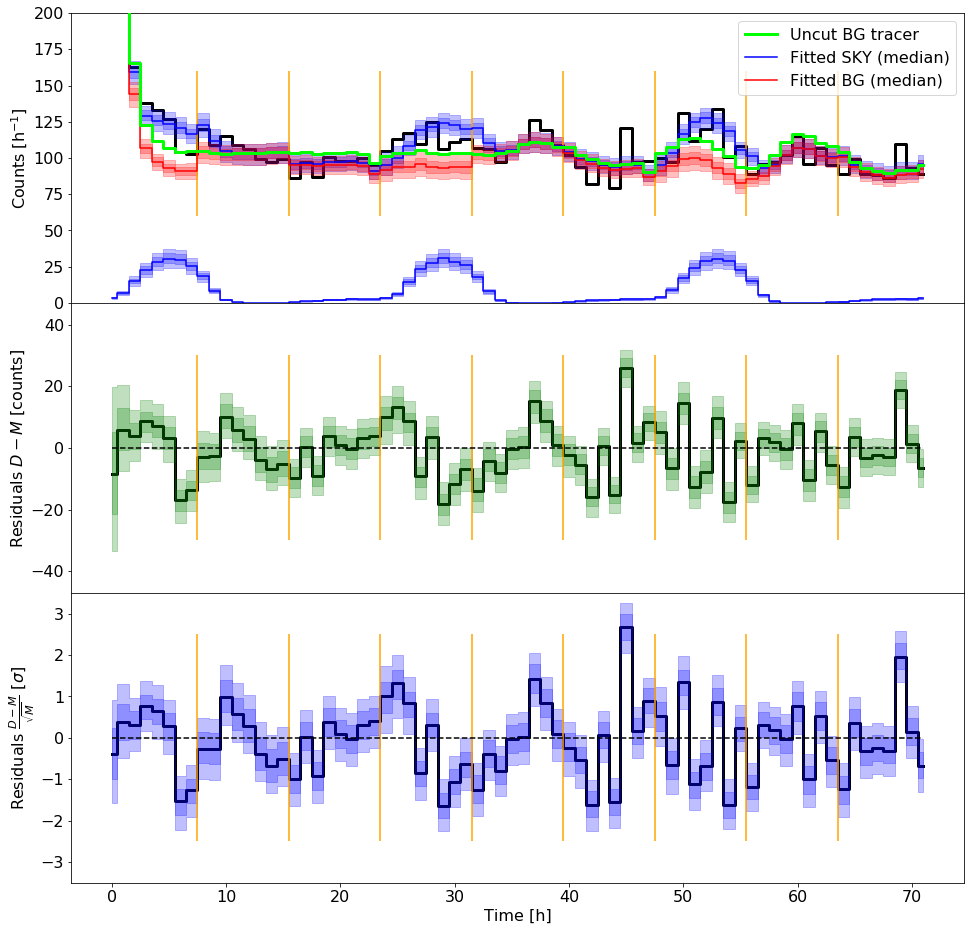

In [263]:
fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(16,16))

plt.subplots_adjust(hspace=0)

ax[0].step(hs,data_hourly,where='mid',color='black',zorder=-1000,linewidth=3)

ax[0].step(hs,tracer,where='mid',color='lime',label='Uncut BG tracer',linewidth=3,zorder=1e4)

s68 = 68.3/2
s95 = 95.4/2

ax[0].fill_between(hs,
                np.percentile(chains3['model_tot'],50+s68,axis=0),
                np.percentile(chains3['model_tot'],50-s68,axis=0),
                color='blue',step='mid',alpha=0.25)

ax[0].fill_between(hs,
                np.percentile(chains3['model_tot'],50+s95,axis=0),
                np.percentile(chains3['model_tot'],50-s95,axis=0),
                color='blue',step='mid',alpha=0.25)

fitted_tot = np.percentile(chains3['model_tot'],50,axis=0)

ax[0].step(hs,fitted_tot,where='mid',color='blue')

ax[0].fill_between(hs,
                np.percentile(chains3['model_bg'],50+s68,axis=0),
                np.percentile(chains3['model_bg'],50-s68,axis=0),
                color='red',step='mid',alpha=0.25)

ax[0].fill_between(hs,
                np.percentile(chains3['model_bg'],50+s95,axis=0),
                np.percentile(chains3['model_bg'],50-s95,axis=0),
                color='red',step='mid',alpha=0.25)


ax[0].fill_between(hs,
                np.percentile(chains3['model_sky'],50+s68,axis=0),
                np.percentile(chains3['model_sky'],50-s68,axis=0),
                color='blue',step='mid',alpha=0.25)

ax[0].fill_between(hs,
                np.percentile(chains3['model_sky'],50+s95,axis=0),
                np.percentile(chains3['model_sky'],50-s95,axis=0),
                color='blue',step='mid',alpha=0.25)

ax[0].step(hs,fitted_sky,color='blue',where='mid',label='Fitted SKY (median)')
ax[0].step(hs,fitted_bg,color='red',where='mid',label='Fitted BG (median)')


ax[1].step(hs,data_hourly-fitted_tot,where='mid',color='black',zorder=-1000,linewidth=3)

ax[1].fill_between(hs,
                 data_hourly-(fitted_tot+fitted_tot_errhi68),
                 data_hourly-(fitted_tot-fitted_tot_errlo68),
                 color='green',alpha=0.25,step='mid')

ax[1].fill_between(hs,
                 data_hourly-(fitted_tot+fitted_tot_errhi95),
                 data_hourly-(fitted_tot-fitted_tot_errlo95),
                 color='green',alpha=0.25,step='mid')


ax[2].step(hs,(data_hourly-fitted_tot)/np.sqrt(fitted_tot),where='mid',color='black',zorder=-1000,linewidth=3)

ax[2].fill_between(hs,
                 (data_hourly-(fitted_tot+fitted_tot_errhi68))/np.sqrt(fitted_tot),
                 (data_hourly-(fitted_tot-fitted_tot_errlo68))/np.sqrt(fitted_tot),
                 color='blue',alpha=0.25,step='mid')

ax[2].fill_between(hs,
                 (data_hourly-(fitted_tot+fitted_tot_errhi95))/np.sqrt(fitted_tot),
                 (data_hourly-(fitted_tot-fitted_tot_errlo95))/np.sqrt(fitted_tot),
                 color='blue',alpha=0.25,step='mid')



ax[1].plot(hs,np.zeros(72),linestyle='--',color='black')
ax[1].set_ylabel(r'Residuals $D-M$ [counts]')

ax[0].set_ylabel(r'Counts [h$^{-1}$]')
#ax[0].set_yscale('log')
ax[0].set_ylim(0,200)
ax[1].set_ylim(-47,47)
ax[2].set_ylim(-3.5,3.5)

ax[2].set_xlabel(r'Time [h]')

ax[0].legend()

ax[2].plot(hs,np.zeros(72),linestyle='--',color='black')
ax[2].set_ylabel(r'Residuals $\frac{D-M}{\sqrt{M}}$ [$\sigma$]')

ax[0].vlines(unique_cuts[1:]-1.5,60,160,color='orange')

ax[1].vlines(unique_cuts[1:]-1.5,-30,30,color='orange')

ax[2].vlines(unique_cuts[1:]-1.5,-2.5,2.5,color='orange')

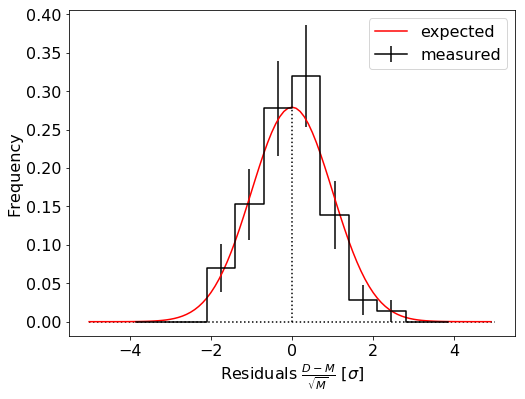

In [264]:
binsize = 0.7
chi2_data = np.histogram((data_hourly-fitted_tot)/np.sqrt(fitted_tot),bins=np.arange(-4.2,4.2,binsize));
plt.errorbar(chi2_data[1][0:-1]+binsize/2,chi2_data[0]/np.sum(chi2_data[0]),
             yerr=np.sqrt(chi2_data[0])/np.sum(chi2_data[0]),drawstyle='steps-mid',label='measured')
xx = np.arange(-5,5,0.1)
plt.plot(xx,np.exp(-0.5*xx**2)/np.sqrt(2*np.pi)*binsize,label='expected')
plt.vlines(0,0,0.28,linestyle=':')
plt.hlines(0,-5,5,linestyle=':')

plt.xlabel(r'Residuals $\frac{D-M}{\sqrt{M}}$ [$\sigma$]')
plt.ylabel('Frequency')
plt.legend()

<h3>Here is the workaround for the model posterior:<br><br>Since the models are not flexible (in this case), we can use the fitted (linear) amplitudes to scale the models according to the sampled 68% (1sigma) and 95% (2sigma) percentile:</h3>

In [75]:
fit_pars_bg = np.percentile(chains3['Abg'],50,axis=0)
fit_errlo68_bg = np.percentile(chains3['Abg'],50,axis=0)-np.percentile(chains3['Abg'],50-68.3/2,axis=0)
fit_errhi68_bg = np.percentile(chains3['Abg'],50+68.3/2,axis=0)-np.percentile(chains3['Abg'],50,axis=0)
fit_errlo95_bg = np.percentile(chains3['Abg'],50,axis=0)-np.percentile(chains3['Abg'],50-95.4/2,axis=0)
fit_errhi95_bg = np.percentile(chains3['Abg'],50+95.4/2,axis=0)-np.percentile(chains3['Abg'],50,axis=0)


fit_pars_flux = np.percentile(chains3['flux'],50,axis=0)
fit_errlo68_flux = np.percentile(chains3['flux'],50,axis=0)-np.percentile(chains3['flux'],50-68.3/2,axis=0)
fit_errhi68_flux = np.percentile(chains3['flux'],50+68.3/2,axis=0)-np.percentile(chains3['flux'],50,axis=0)
fit_errlo95_flux = np.percentile(chains3['flux'],50,axis=0)-np.percentile(chains3['flux'],50-95.4/2,axis=0)
fit_errhi95_flux = np.percentile(chains3['flux'],50+95.4/2,axis=0)-np.percentile(chains3['flux'],50,axis=0)

In [76]:
fitted_bg = np.sum(bg_response_tracer,axis=1)*fit_pars_bg[idx_arr-1]
fitted_bg_errhi68 = np.sum(bg_response_tracer,axis=1)*fit_errhi68_bg[idx_arr-1]
fitted_bg_errlo68 = np.sum(bg_response_tracer,axis=1)*fit_errlo68_bg[idx_arr-1]
fitted_bg_errhi95 = np.sum(bg_response_tracer,axis=1)*fit_errhi95_bg[idx_arr-1]
fitted_bg_errlo95 = np.sum(bg_response_tracer,axis=1)*fit_errlo95_bg[idx_arr-1]
fitted_sky = np.sum(conv_sky_511,axis=1)*fit_pars_flux
fitted_sky_errhi68 = np.sum(conv_sky_511,axis=1)*fit_errhi68_flux
fitted_sky_errlo68 = np.sum(conv_sky_511,axis=1)*fit_errlo68_flux
fitted_sky_errhi95 = np.sum(conv_sky_511,axis=1)*fit_errhi95_flux
fitted_sky_errlo95 = np.sum(conv_sky_511,axis=1)*fit_errlo95_flux
fitted_model = fitted_bg+fitted_sky
fitted_model_errhi68 = np.sqrt(fitted_bg_errhi68**2 + fitted_sky_errhi68**2)
fitted_model_errlo68 = np.sqrt(fitted_bg_errlo68**2 + fitted_sky_errlo68**2)
fitted_model_errhi95 = np.sqrt(fitted_bg_errhi95**2 + fitted_sky_errhi95**2)
fitted_model_errlo95 = np.sqrt(fitted_bg_errlo95**2 + fitted_sky_errlo95**2)

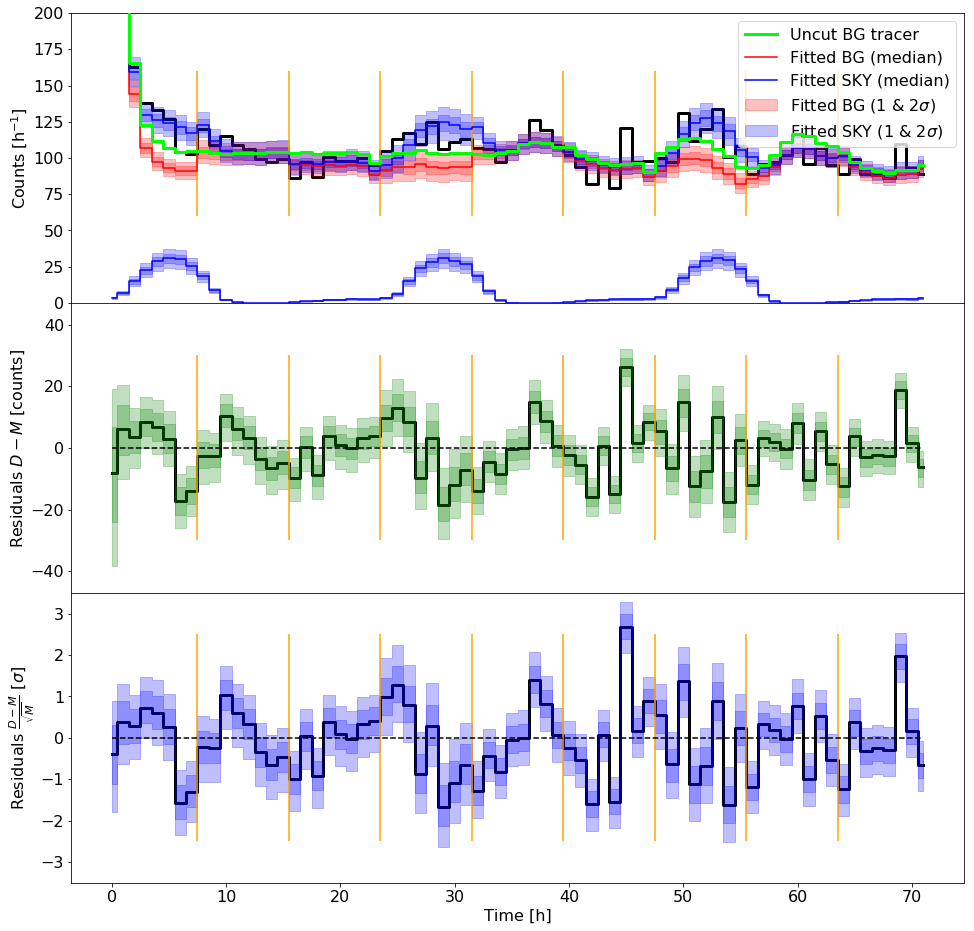

In [82]:
unique_cuts = np.unique(bg_cuts)

fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(16,16))

plt.subplots_adjust(hspace=0)

ax[0].step(hs,data_hourly,where='mid',color='black',zorder=-1000,linewidth=3)

ax[0].step(hs,tracer,where='mid',color='lime',label='Uncut BG tracer',linewidth=3,zorder=1e4)

ax[0].step(hs,fitted_bg,color='red',where='mid',label='Fitted BG (median)')

ax[0].fill_between(hs,
                 fitted_bg+fitted_bg_errhi68,
                 fitted_bg-fitted_bg_errlo68,
                 color='red',alpha=0.25,step='mid')

ax[0].fill_between(hs,
                 fitted_bg+fitted_bg_errhi95,
                 fitted_bg-fitted_bg_errlo95,
                 color='red',alpha=0.25,step='mid',label=r'Fitted BG (1 & 2$\sigma$)')


ax[0].step(hs,fitted_model,color='blue',where='mid')

ax[0].fill_between(hs,
                 fitted_model+fitted_model_errhi68,
                 fitted_model-fitted_model_errlo68,
                 color='blue',alpha=0.25,step='mid')

ax[0].fill_between(hs,
                 fitted_model+fitted_model_errhi95,
                 fitted_model-fitted_model_errlo95,
                 color='blue',alpha=0.25,step='mid')


ax[0].step(hs,fitted_sky,color='blue',where='mid',label='Fitted SKY (median)')

ax[0].fill_between(hs,
                 fitted_sky+fitted_sky_errhi68,
                 fitted_sky-fitted_sky_errlo68,
                 color='blue',alpha=0.25,step='mid')

ax[0].fill_between(hs,
                 fitted_sky+fitted_sky_errhi95,
                 fitted_sky-fitted_sky_errlo95,
                 color='blue',alpha=0.25,step='mid',label=r'Fitted SKY (1 & 2$\sigma$)')

#ax.text(13,30,r'$\Delta$AIC=%3.1f' % min_AIC_arr[c])

#ax.title(r'$N_{par}^{BG}=$%2i' % int(n_par_arr[c]-1))

ax[0].set_ylabel(r'Counts [h$^{-1}$]')
#ax[0].set_yscale('log')
ax[0].set_ylim(0,200)
ax[1].set_ylim(-47,47)
ax[2].set_ylim(-3.5,3.5)

ax[2].set_xlabel(r'Time [h]')

ax[0].legend()


ax[1].step(hs,data_hourly-fitted_model,where='mid',color='black',zorder=-1000,linewidth=3)

ax[1].fill_between(hs,
                 data_hourly-(fitted_model+fitted_model_errhi68),
                 data_hourly-(fitted_model-fitted_model_errlo68),
                 color='green',alpha=0.25,step='mid')

ax[1].fill_between(hs,
                 data_hourly-(fitted_model+fitted_model_errhi95),
                 data_hourly-(fitted_model-fitted_model_errlo95),
                 color='green',alpha=0.25,step='mid')

ax[1].plot(hs,np.zeros(72),linestyle='--',color='black')
ax[1].set_ylabel(r'Residuals $D-M$ [counts]')

ax[2].step(hs,(data_hourly-fitted_model)/np.sqrt(fitted_model),where='mid',color='black',zorder=-1000,linewidth=3)

ax[2].fill_between(hs,
                 (data_hourly-(fitted_model+fitted_model_errhi68))/np.sqrt(fitted_model),
                 (data_hourly-(fitted_model-fitted_model_errlo68))/np.sqrt(fitted_model),
                 color='blue',alpha=0.25,step='mid')

ax[2].fill_between(hs,
                 (data_hourly-(fitted_model+fitted_model_errhi95))/np.sqrt(fitted_model),
                 (data_hourly-(fitted_model-fitted_model_errlo95))/np.sqrt(fitted_model),
                 color='blue',alpha=0.25,step='mid')

ax[2].plot(hs,np.zeros(72),linestyle='--',color='black')
ax[2].set_ylabel(r'Residuals $\frac{D-M}{\sqrt{M}}$ [$\sigma$]')

ax[0].vlines(unique_cuts[1:]-1.5,60,160,color='orange')

ax[1].vlines(unique_cuts[1:]-1.5,-30,30,color='orange')

ax[2].vlines(unique_cuts[1:]-1.5,-2.5,2.5,color='orange')

#ax.tight_layout()

#ax.savefig('BG_scaling_AIC_stat.pdf')

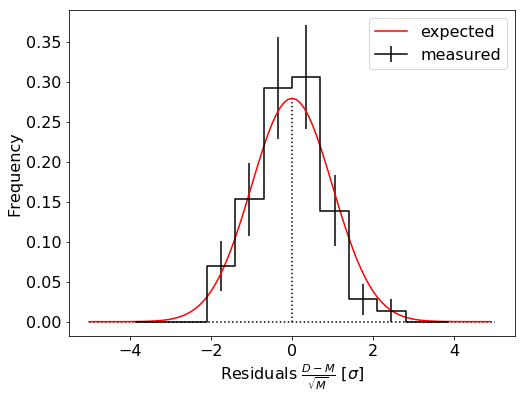

In [91]:
binsize = 0.7
chi2_data = np.histogram((data_hourly-fitted_model)/np.sqrt(fitted_model),bins=np.arange(-4.2,4.2,binsize));
plt.errorbar(chi2_data[1][0:-1]+binsize/2,chi2_data[0]/np.sum(chi2_data[0]),
             yerr=np.sqrt(chi2_data[0])/np.sum(chi2_data[0]),drawstyle='steps-mid',label='measured')
xx = np.arange(-5,5,0.1)
plt.plot(xx,np.exp(-0.5*xx**2)/np.sqrt(2*np.pi)*binsize,label='expected')
plt.vlines(0,0,0.28,linestyle=':')
plt.hlines(0,-5,5,linestyle=':')

plt.xlabel(r'Residuals $\frac{D-M}{\sqrt{M}}$ [$\sigma$]')
plt.ylabel('Frequency')
plt.legend()

<h3>Most "normalised residuals" are between -3 and +3 sigma (in this presentation of the data), which is providing a good estimate of how much off we are using this model. Note that each data point here consists of 4587 bins from the COSI data space (phi, psi, chi).<br><br>Now, we check the goodness-of-fit by using posterior predictive checks, i.e. the probability of obtaining the data that we got from the posterior we found for our parameters. This is a convolution of the likelihood of our data with the total posterior, providing (here) Poisson-distributed samples in each data bin. We visualise this in time and in the COSI data space dimension:</h3>

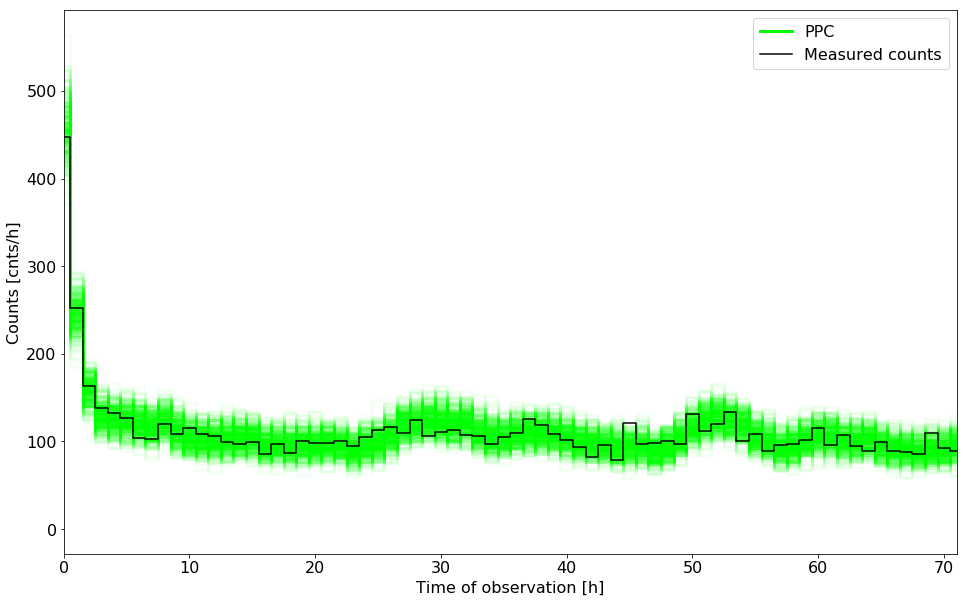

In [85]:
plt.figure(figsize=(16,10))
for i in range(nt):
    plt.step(hs,np.sum(chains3['ppc'].reshape(nt,n_hours,tmp_data.shape[1]),axis=2)[i,:],
             alpha=0.05,where='mid',color='lime',linewidth=3)
plt.step(0,0,where='mid',label='PPC',color='lime',linewidth=3) # only for the label
plt.step(hs,data_hourly,color='black',where='mid',label='Measured counts')

plt.xlabel('Time of observation [h]')
plt.ylabel('Counts [cnts/h]')

plt.xlim(0,71.)

plt.legend()

#plt.savefig('COSIsim_ppc_time.png')

<h3>We can see that all hour (time-binned) data points are inside the posterior predictive samples from the fitted model. This means, it is 'plausible' that the data we got come from the generating process (physics, statistics) we included in our model.<br><br>If there were points large deviating from the prediction (e.g. if the point at hour ~ 45 was much further away), we would know that the model (or parts of it) are not sufficient to explain the data. (this can(!) be similar to calculating the (reduced) chi2 of a fit).</h3>

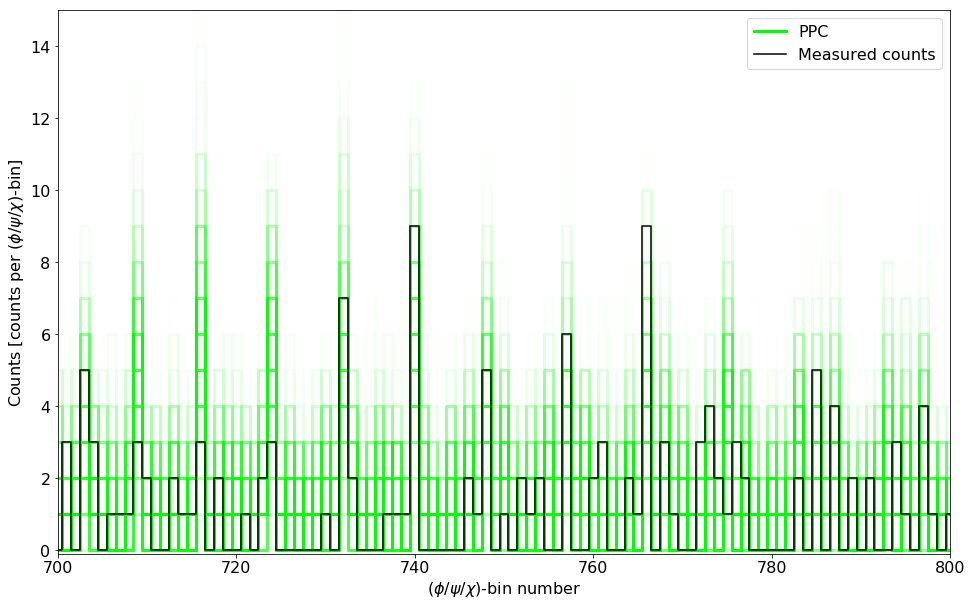

In [89]:
arbdim = np.arange(tmp_data.shape[1])
plt.figure(figsize=(16,10))
for i in range(nt):
    plt.step(arbdim,np.sum(chains3['ppc'].reshape(nt,n_hours,tmp_data.shape[1]),axis=1)[i,:],
             alpha=0.01,where='mid',color='lime',linewidth=3)
plt.step(0,0,where='mid',label='PPC',color='lime',linewidth=3) # label
plt.step(arbdim,np.sum(tmp_data,axis=0),color='black',where='mid',label='Measured counts')

plt.xlabel('($\phi$/$\psi$/$\chi$)-bin number')
plt.ylabel(r'Counts [counts per ($\phi$/$\psi$/$\chi$)-bin]')
plt.xlim(700,800)
plt.ylim(-0.1,15)

plt.legend(loc=1)

#plt.savefig('COSIsim_ppc_angles07.png')

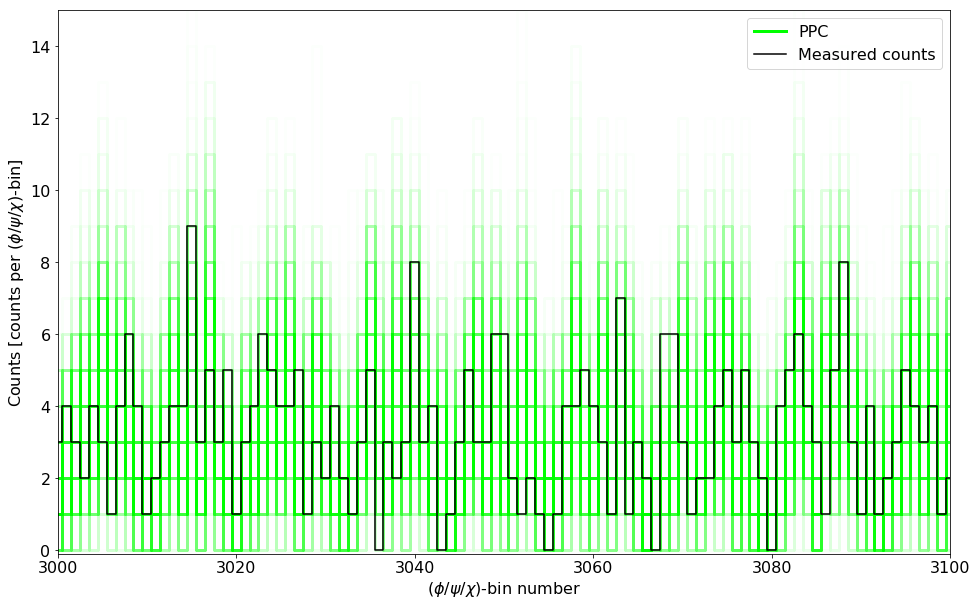

In [90]:
arbdim = np.arange(tmp_data.shape[1])
plt.figure(figsize=(16,10))
for i in range(nt):
    plt.step(arbdim,np.sum(chains3['ppc'].reshape(nt,n_hours,tmp_data.shape[1]),axis=1)[i,:],
             alpha=0.01,where='mid',color='lime',linewidth=3)
plt.step(0,0,where='mid',label='PPC',color='lime',linewidth=3) # label
plt.step(arbdim,np.sum(tmp_data,axis=0),color='black',where='mid',label='Measured counts')

plt.xlabel('($\phi$/$\psi$/$\chi$)-bin number')
plt.ylabel(r'Counts [counts per ($\phi$/$\psi$/$\chi$)-bin]')
plt.xlim(3000,3100)
plt.ylim(-0.1,15)

plt.legend(loc=1)

#plt.savefig('COSIsim_ppc_angles30.png')

<h3>Likewise, in excerpts of the COSI data space bins (each point now including 72 hours of observation), we see that the model predicted counts and the measured counts are matching. The transparency provides an estimate of how often a model would predict this number. Note that the predictions (green) are integer numbers as they are Poisson-samples from the fitted model.</h3>

In [107]:
chains3['ppc'].shape,tmp_data.shape

((500, 330264), (72, 4587))

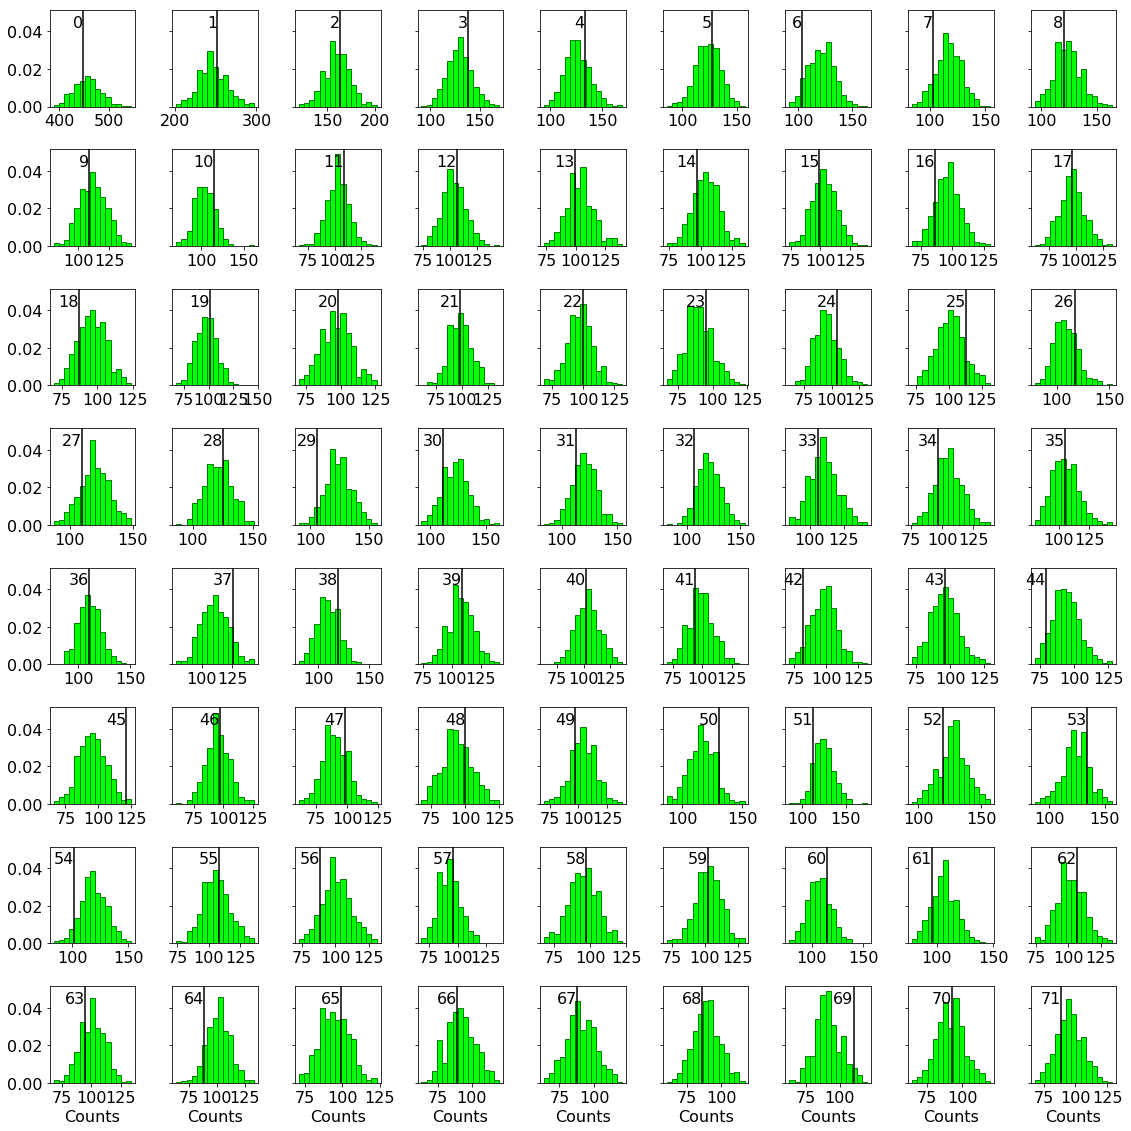

In [269]:
fig, axes = plt.subplots(nrows=8,ncols=9,figsize=(16,16),sharey=True)

cnt = 0

for i in range(8):
    for j in range(9):
        
        axes[i,j].hist(np.sum(chains3['ppc'].reshape(nt,n_hours,tmp_data.shape[1]),axis=2)[:,cnt],
                       ec='green',fc='lime', bins=15, density=True)
        axes[i,j].axvline(np.sum(tmp_data,axis=1)[cnt],color='black')
        axes[i,j].text(np.sum(tmp_data,axis=1)[cnt],0.0425,str(cnt),horizontalalignment='right')
        if i == 7:
            axes[i,j].set_xlabel('Counts')
        cnt+=1
        
plt.tight_layout()

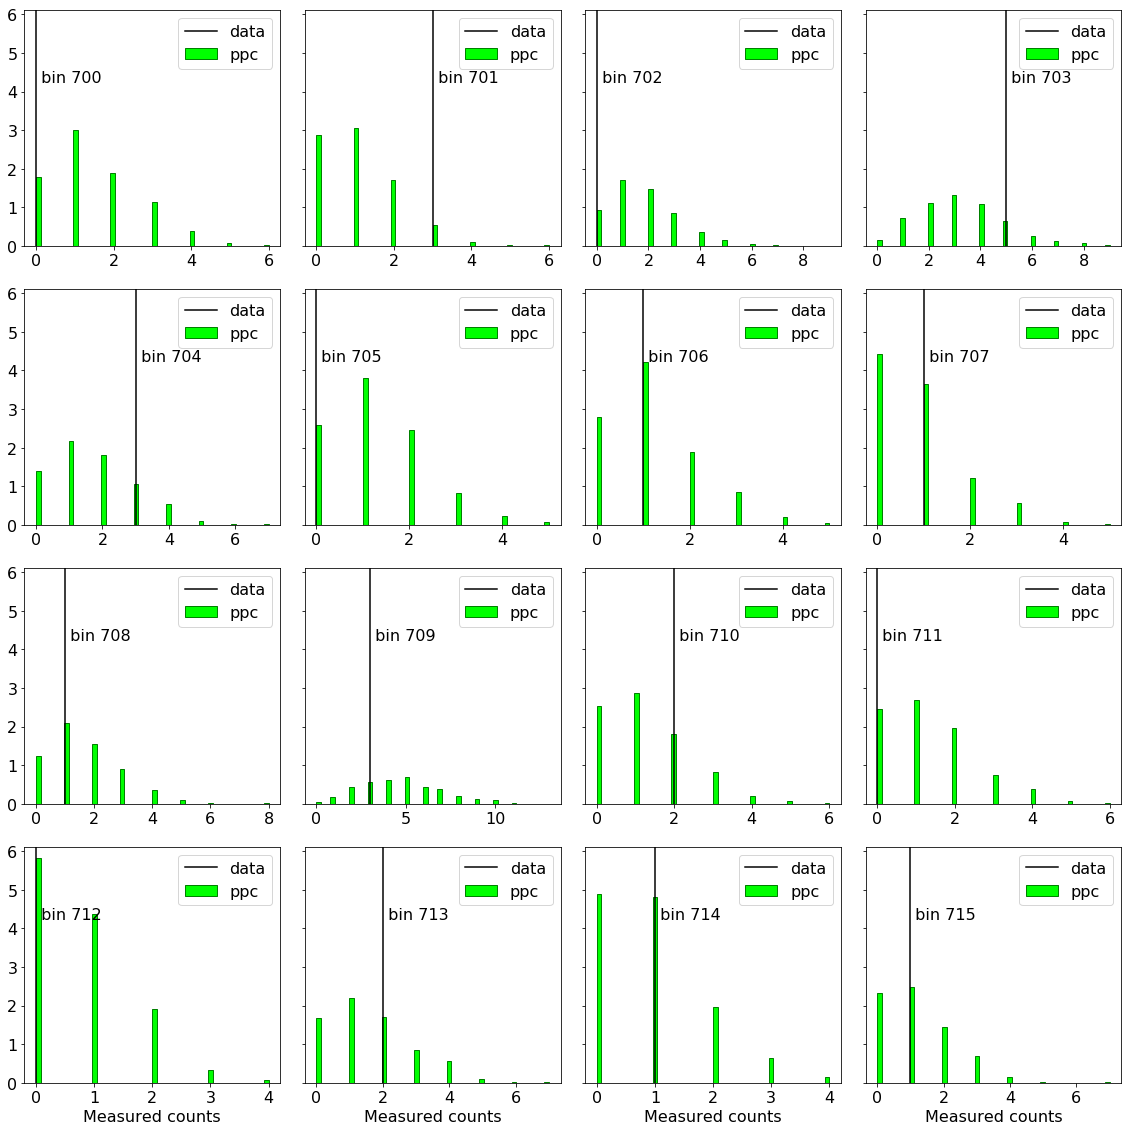

In [268]:
offset = 700

fig, axes = plt.subplots(nrows=4,ncols=4,figsize=(16,16),sharey=True)

cnt = 0

for i in range(4):
    for j in range(4):
        
        axes[i,j].hist(np.sum(chains3['ppc'].reshape(nt,n_hours,tmp_data.shape[1]),axis=1)[:,cnt+offset],
                       ec='green',fc='lime', bins=50, density=True, label='ppc')
        axes[i,j].axvline(np.sum(tmp_data,axis=0)[cnt+offset],color='black', label='data')
        axes[i,j].text(np.sum(tmp_data,axis=0)[cnt+offset],4.25,' bin '+str(cnt+offset),horizontalalignment='left')
        axes[i,j].legend()
        if i == 3:
            axes[i,j].set_xlabel(r'Measured counts')
        cnt+=1
        
plt.tight_layout()

<h3>Now that we can fit all this, we will start over and determine how much of the simulated signal we can find.<br><br>We start from a symmetric Gaussian at (l/b)=(0/0), and change its radius to get a likelihood profile. When we found a best fit, we try adding other components.<br><br>TBD!</h3>